# Library Imports

In [ ]:
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, f_oneway, chi2_contingency, pearsonr
import scipy.stats as stats

try:
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    from statsmodels.stats.diagnostic import het_breuschpagan, linear_rainbow
    HAS_SM = True
except ImportError:
    HAS_SM = False
    print("Warning: statsmodels not found. Falling back to scikit-learn for basic regression.")
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score

from google.colab import files


if os.path.exists("raw_data.csv"):
    df = pd.read_csv("raw_data.csv")
else:
    uploaded = files.upload()
    df = pd.read_csv(list(uploaded.keys())[0])

#df.head()

# DATA Processing






In [ ]:
print("Shape:", df.shape)
print("\nColumn Names:\n", df.columns.tolist())
print("\nMissing Values:\n", df.isna().sum())
df.info()

Shape: (115, 15)

Column Names:
 ['Timestamp', 'Year of Study:', 'Gender:', 'Age:', 'CGPA  (Optional)  :', 'How many hours do you spend on studying per week?', 'How many courses are you currently enrolled in?', 'Do you participate in extra-curricular activities?', 'How many hours per week do you usually spend on extracurricular activities?  ', 'Do you have a part-time job?', 'How many hours per week do you usually work at your part-time job?  ', 'On a scale of 1–5, how would you rate your stress level this semester? ', 'On a scale of 1–5, how would you rate your anxiety level? ', 'On average, how many hours of sleep do you get per night?', 'On a scale of 1–10, how would you rate your overall sleep quality?']

Missing Values:
 Timestamp                                                                         0
Year of Study:                                                                    0
Gender:                                                                           0
Age:        

In [ ]:
df = df.drop('Timestamp', axis=1)
df = df.rename(columns={
    "Year of Study:": "year_of_study",
    "Gender:": "gender",
    "Age:": "age",
    "CGPA  (Optional)  :": "cgpa",
    "How many hours do you spend on studying per week?": "study_hours_per_week",
    "How many courses are you currently enrolled in?": "courses_enrolled",
    "Do you participate in extra-curricular activities?": "extracurricular",
    "How many hours per week do you usually spend on extracurricular activities?  ": "extracurricular_hours",
    "Do you have a part-time job?": "job",
    "How many hours per week do you usually work at your part-time job?  ": "job_hours_per_week",
    "On a scale of 1–5, how would you rate your stress level this semester? ": "stress_1to5",
    "On a scale of 1–5, how would you rate your anxiety level? ": "anxiety_1to5",
    "On average, how many hours of sleep do you get per night?": "sleep_hours",
    "On a scale of 1–10, how would you rate your overall sleep quality?": "sleep_quality_1to10"
})

df.describe(include='all')



,year_of_study,gender,age,cgpa,study_hours_per_week,courses_enrolled,extracurricular,extracurricular_hours,job,job_hours_per_week,stress_1to5,anxiety_1to5,sleep_hours,sleep_quality_1to10
count,115,115,115.000000,49.000000,115.000000,115.000000,115,51.000000,115,27.000000,115.000000,115.000000,115.000000,115.000000
unique,4,2,NaN,NaN,NaN,NaN,2,NaN,2,NaN,NaN,NaN,NaN,NaN
top,2nd Year (36–70 credits),Male,NaN,NaN,NaN,NaN,No,NaN,No,NaN,NaN,NaN,NaN,NaN
freq,43,80,NaN,NaN,NaN,NaN,65,NaN,85,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,22.286957,3.316939,12.526087,3.960870,NaN,8.901961,NaN,18.981481,3.869565,3.652174,5.665217,5.739130
std,NaN,NaN,1.302933,0.770395,11.371873,2.639235,NaN,11.881506,NaN,13.198544,1.021881,1.068229,1.300678,1.938017
min,NaN,NaN,19.000000,0.000000,0.500000,1.000000,NaN,1.000000,NaN,1.500000,1.000000,1.000000,3.000000,1.000000
25%,NaN,NaN,22.000000,3.210000,4.000000,3.000000,NaN,2.500000,NaN,9.000000,3.000000,3.000000,5.000000,4.000000
50%,NaN,NaN,22.000000,3.500000,10.000000,3.000000,NaN,5.000000,NaN,18.000000,4.000000,4.000000,6.000000,6.000000
75%,NaN,NaN,23.000000,3.710000,17.000000,4.000000,NaN,10.000000,NaN,20.000000,5.000000,4.000000,6.000000,7.000000


In [ ]:
# Map year of study to numeric
year_map = {"1st Year (0–35 credits)": 1, "2nd Year (36–70 credits)": 2, "3rd Year (71–105 credits)": 3, "4th Year (106+ credits)": 4}

df["year_of_study"] = df["year_of_study"].map(year_map).astype(int)

# Map Yes/No to binary
df["extracurricular"] = df["extracurricular"].map({"Yes": 1, "No": 0}).astype(int)
df["job"] = df["job"].map({"Yes": 1, "No": 0}).astype(int)

# Handle missing values
df["cgpa"] = df["cgpa"].fillna(df["cgpa"].mean())
df.loc[(df["extracurricular"]==1) & (df["extracurricular_hours"].isna()), "extracurricular_hours"] = df.loc[df["extracurricular"]==1, "extracurricular_hours"].median()
df.loc[df["extracurricular"]==0, "extracurricular_hours"] = 0
df.loc[(df["job"]==1) & (df["job_hours_per_week"].isna()), "job_hours_per_week"] = df.loc[df["job"]==1, "job_hours_per_week"].median()
df.loc[df["job"]==0, "job_hours_per_week"] = 0


# Cap unrealistic cgpa
df.loc[df["cgpa"] < 1, "cgpa"] = df["cgpa"].median()

# Cap unrealistic courses
df.loc[df["courses_enrolled"] < 2, "courses_enrolled"] = df["courses_enrolled"].median()
df.loc[df["courses_enrolled"] > 6, "courses_enrolled"] = df["courses_enrolled"].median()

# Cap unrealistic Hours
df.loc[df["extracurricular_hours"] > 50, "extracurricular_hours"] = df["extracurricular_hours"].median()
df.loc[df["study_hours_per_week"] > 50, "study_hours_per_week"] = df["study_hours_per_week"].median()


# Convert to proper types
df["courses_enrolled"] = df["courses_enrolled"].astype(int)
df["extracurricular_hours"] = df["extracurricular_hours"].astype(int)
df["job_hours_per_week"] = df["job_hours_per_week"].astype(int)
df["sleep_hours"] = df["sleep_hours"].astype(int)
df["study_hours_per_week"] = df["study_hours_per_week"].astype(int)


print(df.dtypes)
df.describe(include='all')

year_of_study              int64
gender                    object
age                        int64
cgpa                     float64
study_hours_per_week       int64
courses_enrolled           int64
extracurricular            int64
extracurricular_hours      int64
job                        int64
job_hours_per_week         int64
stress_1to5                int64
anxiety_1to5               int64
sleep_hours                int64
sleep_quality_1to10        int64
dtype: object


,year_of_study,gender,age,cgpa,study_hours_per_week,courses_enrolled,extracurricular,extracurricular_hours,job,job_hours_per_week,stress_1to5,anxiety_1to5,sleep_hours,sleep_quality_1to10
count,115.000000,115,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
unique,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,Male,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.313043,NaN,22.286957,3.372886,12.000000,3.365217,0.434783,3.478261,0.260870,4.869565,3.869565,3.652174,5.634783,5.739130
std,0.892122,NaN,1.302933,0.254970,10.011397,0.705000,0.497898,6.583269,0.441031,10.380922,1.021881,1.068229,1.320091,1.938017
min,1.000000,NaN,19.000000,2.570000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,1.000000
25%,2.000000,NaN,22.000000,3.316939,4.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,5.000000,4.000000
50%,2.000000,NaN,22.000000,3.316939,10.000000,3.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4.000000,6.000000,6.000000
75%,3.000000,NaN,23.000000,3.385000,16.000000,4.000000,1.000000,5.500000,1.000000,3.000000,5.000000,4.000000,6.000000,7.000000


In [ ]:
df.to_csv('processed_data.csv', index=False)

#Exploratory Data Analysis (EDA)

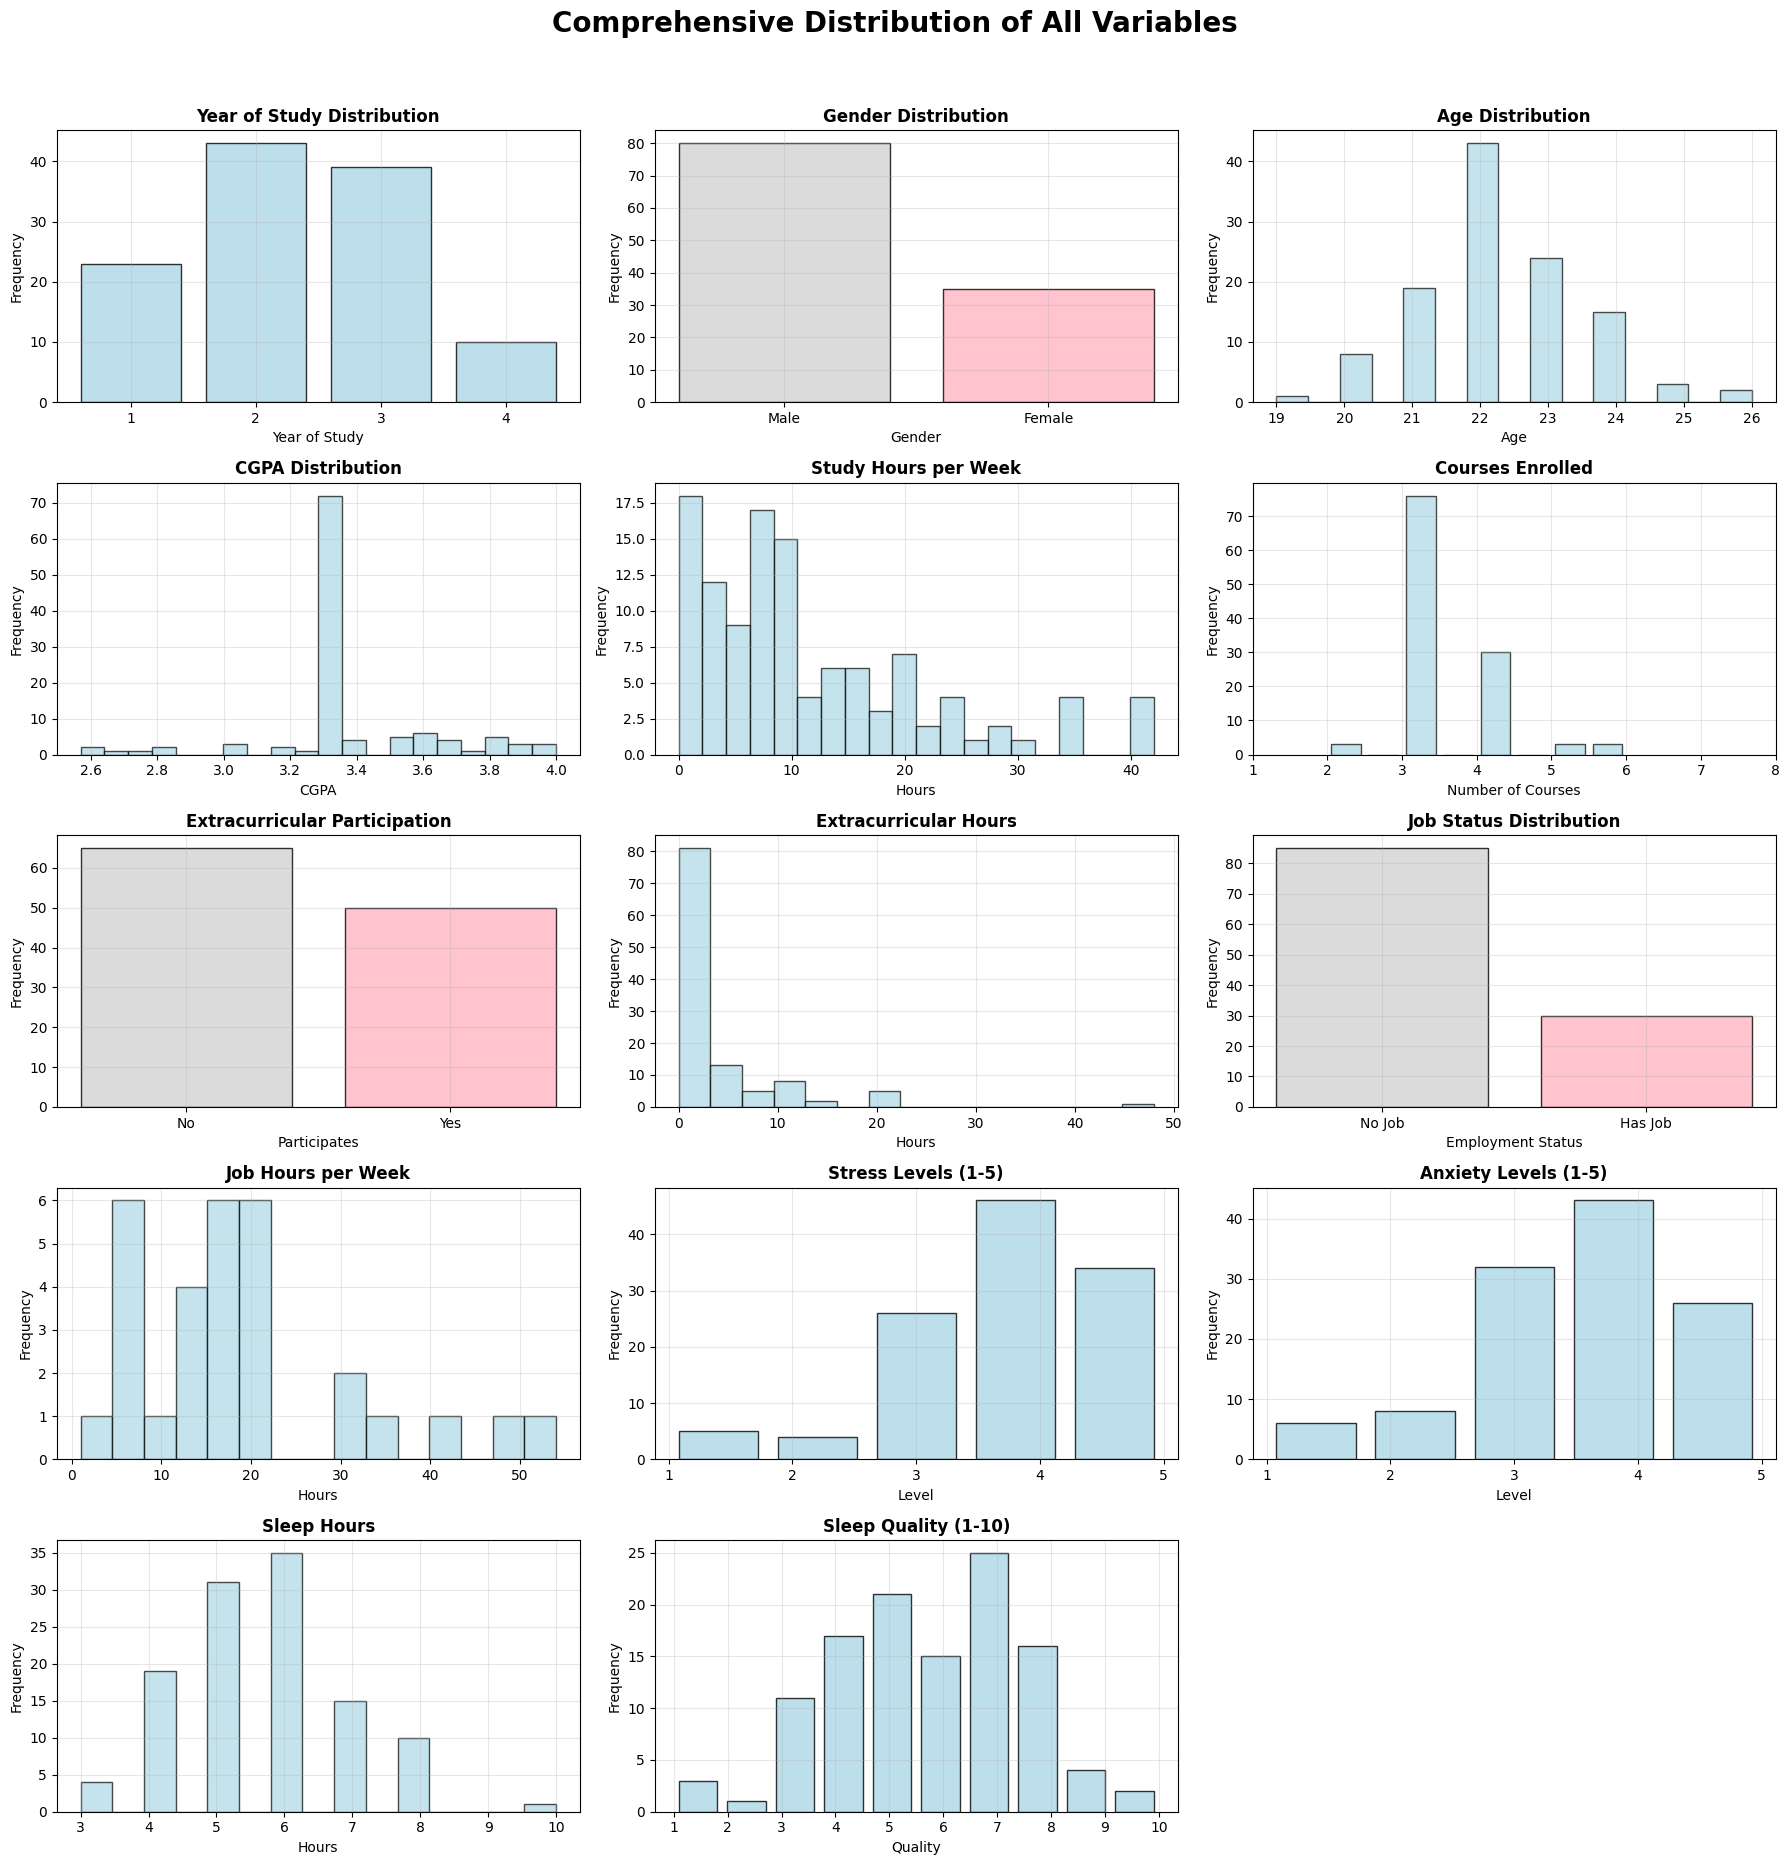

In [ ]:
# 4.1.1. distributions

fig, axes = plt.subplots(5, 3, figsize=(18, 20))
fig.suptitle('Comprehensive Distribution of All Variables', fontsize=20, fontweight='bold')

# Year of study distribution
year_counts = df['year_of_study'].value_counts().sort_index()
axes[0,0].bar(year_counts.index, year_counts.values, alpha=0.8, color='lightblue', edgecolor='black')
axes[0,0].set_title('Year of Study Distribution', fontweight='bold')
axes[0,0].set_xlabel('Year of Study')
axes[0,0].set_ylabel('Frequency')
axes[0,0].set_xticks(year_counts.index)
axes[0,0].grid(alpha=0.3)

# Gender distribution
gender_counts = df['gender'].value_counts()
axes[0,1].bar(gender_counts.index, gender_counts.values, alpha=0.8, color=['lightgray', 'lightpink'], edgecolor='black')
axes[0,1].set_title('Gender Distribution', fontweight='bold')
axes[0,1].set_xlabel('Gender')
axes[0,1].set_ylabel('Frequency')
axes[0,1].grid(alpha=0.3)

# Age distribution
axes[0,2].hist(df['age'], bins=15, alpha=0.7, edgecolor='black', color='lightblue')
axes[0,2].set_title('Age Distribution', fontweight='bold')
axes[0,2].set_xlabel('Age')
axes[0,2].set_ylabel('Frequency')
axes[0,2].grid(alpha=0.3)

# CGPA distribution
axes[1,0].hist(df['cgpa'], bins=20, alpha=0.7, edgecolor='black', color='lightblue')
axes[1,0].set_title('CGPA Distribution', fontweight='bold')
axes[1,0].set_xlabel('CGPA')
axes[1,0].set_ylabel('Frequency')
axes[1,0].grid(alpha=0.3)

# Study hours distribution
axes[1,1].hist(df['study_hours_per_week'], bins=20, alpha=0.7, edgecolor='black', color='lightblue')
axes[1,1].set_title('Study Hours per Week', fontweight='bold')
axes[1,1].set_xlabel('Hours')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(alpha=0.3)

# Courses enrolled distribution
axes[1,2].hist(df['courses_enrolled'], bins=8, alpha=0.7, edgecolor='black', color='lightblue', rwidth=0.8)
axes[1,2].set_title('Courses Enrolled', fontweight='bold')
axes[1,2].set_xlabel('Number of Courses')
axes[1,2].set_ylabel('Frequency')
axes[1,2].set_xticks(range(1, 9))
axes[1,2].grid(alpha=0.3)

# Extracurricular participation
extracurricular_counts = df['extracurricular'].value_counts()
axes[2,0].bar(['No', 'Yes'], extracurricular_counts.values, alpha=0.8, color=['lightgray', 'lightpink'], edgecolor='black')
axes[2,0].set_title('Extracurricular Participation', fontweight='bold')
axes[2,0].set_xlabel('Participates')
axes[2,0].set_ylabel('Frequency')
axes[2,0].grid(alpha=0.3)

# Extracurricular hours distribution
axes[2,1].hist(df['extracurricular_hours'], bins=15, alpha=0.7, edgecolor='black', color='lightblue')
axes[2,1].set_title('Extracurricular Hours', fontweight='bold')
axes[2,1].set_xlabel('Hours')
axes[2,1].set_ylabel('Frequency')
axes[2,1].grid(alpha=0.3)

# Job status distribution
job_counts = df['job'].value_counts()
axes[2,2].bar(['No Job', 'Has Job'], job_counts.values, alpha=0.8, color=['lightgray', 'lightpink'], edgecolor='black')
axes[2,2].set_title('Job Status Distribution', fontweight='bold')
axes[2,2].set_xlabel('Employment Status')
axes[2,2].set_ylabel('Frequency')
axes[2,2].grid(alpha=0.3)

# Job hours distribution
axes[3,0].hist(df[df['job_hours_per_week'] > 0]['job_hours_per_week'], bins=15, alpha=0.7, edgecolor='black', color='lightblue')
axes[3,0].set_title('Job Hours per Week', fontweight='bold')
axes[3,0].set_xlabel('Hours')
axes[3,0].set_ylabel('Frequency')
axes[3,0].grid(alpha=0.3)

# Stress level distribution
axes[3,1].hist(df['stress_1to5'], bins=5, alpha=0.8, edgecolor='black', color='lightblue', rwidth=0.8)
axes[3,1].set_title('Stress Levels (1-5)', fontweight='bold')
axes[3,1].set_xlabel('Level')
axes[3,1].set_ylabel('Frequency')
axes[3,1].set_xticks(range(1, 6))
axes[3,1].grid(alpha=0.3)

# Anxiety level distribution
axes[3,2].hist(df['anxiety_1to5'], bins=5, alpha=0.8, edgecolor='black', color='lightblue', rwidth=0.8)
axes[3,2].set_title('Anxiety Levels (1-5)', fontweight='bold')
axes[3,2].set_xlabel('Level')
axes[3,2].set_ylabel('Frequency')
axes[3,2].set_xticks(range(1, 6))
axes[3,2].grid(alpha=0.3)

# Sleep hours distribution
axes[4,0].hist(df['sleep_hours'], bins=15, alpha=0.7, edgecolor='black', color='lightblue')
axes[4,0].set_title('Sleep Hours', fontweight='bold')
axes[4,0].set_xlabel('Hours')
axes[4,0].set_ylabel('Frequency')
axes[4,0].grid(alpha=0.3)

# Sleep quality distribution
axes[4,1].hist(df['sleep_quality_1to10'], bins=10, alpha=0.8, edgecolor='black', color='lightblue', rwidth=0.8)
axes[4,1].set_title('Sleep Quality (1-10)', fontweight='bold')
axes[4,1].set_xlabel('Quality')
axes[4,1].set_ylabel('Frequency')
axes[4,1].set_xticks(range(1, 11))
axes[4,1].grid(alpha=0.3)

axes[4,2].set_visible(False)

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()

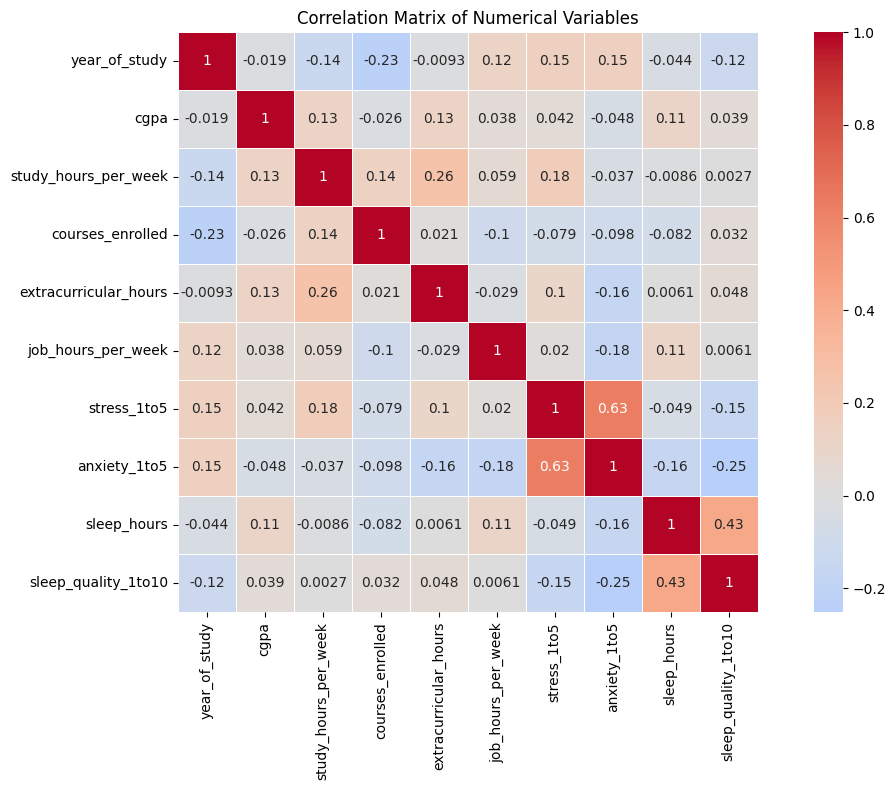

In [ ]:
# 4.1.2. Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_cols = ['year_of_study','cgpa', 'study_hours_per_week', 'courses_enrolled',
                'extracurricular_hours', 'job_hours_per_week',
                'stress_1to5', 'anxiety_1to5', 'sleep_hours', 'sleep_quality_1to10']
correlation_matrix = df[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Variables')
plt.tight_layout()
plt.show()

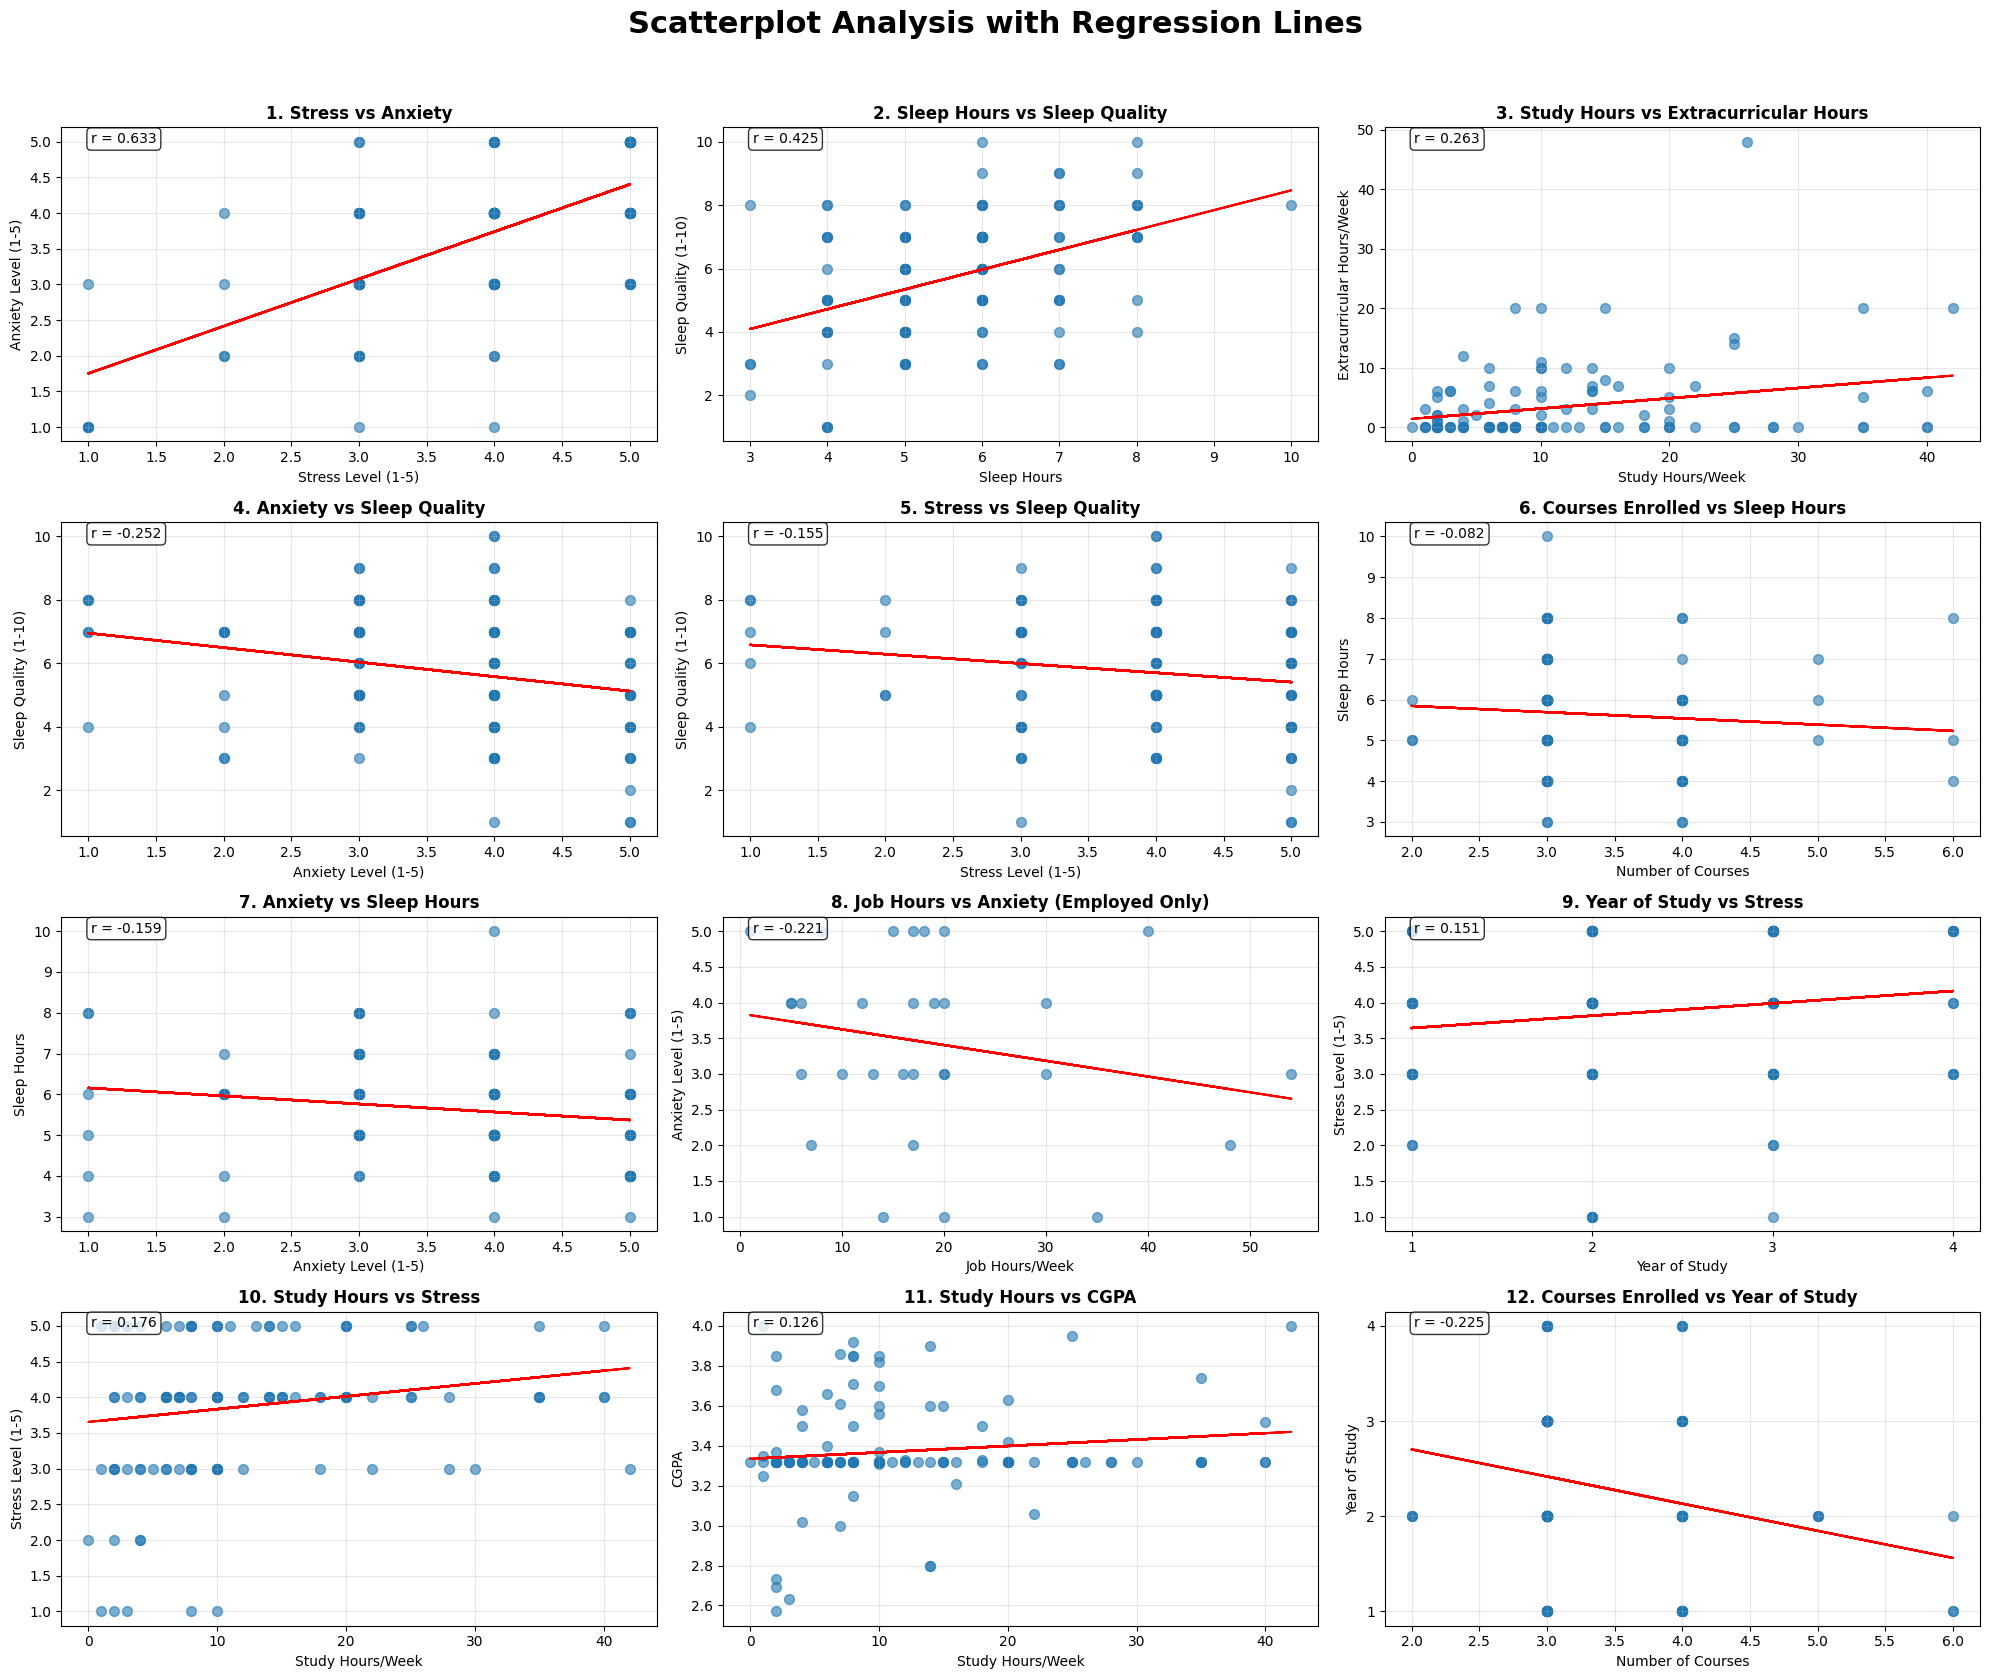

Correlation Summary with Regression Equations and R-squared:
Stress vs Anxiety                  : r =  0.633 | R² = 0.401 | y = 0.662x + 1.091
Sleep Hours vs Sleep Quality       : r =  0.425 | R² = 0.181 | y = 0.624x + 2.221
Study Hours vs Extracurricular Hours: r =  0.263 | R² = 0.069 | y = 0.173x + 1.400
Anxiety vs Sleep Quality           : r = -0.252 | R² = 0.063 | y = -0.457x + 7.408
Stress vs Sleep Quality            : r = -0.155 | R² = 0.024 | y = -0.293x + 6.874
Courses Enrolled vs Sleep Hours    : r = -0.082 | R² = 0.007 | y = -0.153x + 6.149
Anxiety vs Sleep Hours             : r = -0.159 | R² = 0.025 | y = -0.197x + 6.354
Job Hours vs Anxiety               : r = -0.221 | R² = 0.049 | y = -0.022x + 3.846
Year of Study vs Stress            : r =  0.151 | R² = 0.023 | y = 0.173x + 3.469
Study Hours vs Stress              : r =  0.176 | R² = 0.031 | y = 0.018x + 3.654
Study Hours vs CGPA                : r =  0.126 | R² = 0.016 | y = 0.003x + 3.334
Courses Enrolled vs Year of Stu

In [ ]:
# Scatterplot Matrix with Regression Lines
fig, axes = plt.subplots(4, 3, figsize=(20, 18))
fig.suptitle('Scatterplot Analysis with Regression Lines', fontsize=22, fontweight='bold', y=0.98)

# 1. Stress vs Anxiety
x, y = df['stress_1to5'], df['anxiety_1to5']
axes[0,0].scatter(x, y, alpha=0.6, s=50)
# Add regression line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[0,0].plot(x, p(x), "red")
axes[0,0].set_title('1. Stress vs Anxiety', fontweight='bold', fontsize=12)
axes[0,0].set_xlabel('Stress Level (1-5)')
axes[0,0].set_ylabel('Anxiety Level (1-5)')
axes[0,0].grid(alpha=0.3)
corr = x.corr(y)
axes[0,0].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[0,0].transAxes,
              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 2. Sleep Hours vs Sleep Quality
x, y = df['sleep_hours'], df['sleep_quality_1to10']
axes[0,1].scatter(x, y, alpha=0.6, s=50)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[0,1].plot(x, p(x), "red")
axes[0,1].set_title('2. Sleep Hours vs Sleep Quality', fontweight='bold', fontsize=12)
axes[0,1].set_xlabel('Sleep Hours')
axes[0,1].set_ylabel('Sleep Quality (1-10)')
axes[0,1].grid(alpha=0.3)
corr = x.corr(y)
axes[0,1].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[0,1].transAxes,
              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 3. Study Hours vs Extracurricular Hours
x, y = df['study_hours_per_week'], df['extracurricular_hours']
axes[0,2].scatter(x, y, alpha=0.6, s=50)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[0,2].plot(x, p(x), "red")
axes[0,2].set_title('3. Study Hours vs Extracurricular Hours', fontweight='bold', fontsize=12)
axes[0,2].set_xlabel('Study Hours/Week')
axes[0,2].set_ylabel('Extracurricular Hours/Week')
axes[0,2].grid(alpha=0.3)
corr = x.corr(y)
axes[0,2].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[0,2].transAxes,
              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 4. Anxiety vs Sleep Quality
x, y = df['anxiety_1to5'], df['sleep_quality_1to10']
axes[1,0].scatter(x, y, alpha=0.6,  s=50)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[1,0].plot(x, p(x), "red")
axes[1,0].set_title('4. Anxiety vs Sleep Quality', fontweight='bold', fontsize=12)
axes[1,0].set_xlabel('Anxiety Level (1-5)')
axes[1,0].set_ylabel('Sleep Quality (1-10)')
axes[1,0].grid(alpha=0.3)
corr = x.corr(y)
axes[1,0].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[1,0].transAxes,
              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 5. Stress vs Sleep Quality
x, y = df['stress_1to5'], df['sleep_quality_1to10']
axes[1,1].scatter(x, y, alpha=0.6,  s=50)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[1,1].plot(x, p(x), "red")
axes[1,1].set_title('5. Stress vs Sleep Quality', fontweight='bold', fontsize=12)
axes[1,1].set_xlabel('Stress Level (1-5)')
axes[1,1].set_ylabel('Sleep Quality (1-10)')
axes[1,1].grid(alpha=0.3)
corr = x.corr(y)
axes[1,1].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[1,1].transAxes,
              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 6. Courses Enrolled vs Sleep Hours
x, y = df['courses_enrolled'], df['sleep_hours']
axes[1,2].scatter(x, y, alpha=0.6,  s=50)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[1,2].plot(x, p(x), "red")
axes[1,2].set_title('6. Courses Enrolled vs Sleep Hours', fontweight='bold', fontsize=12)
axes[1,2].set_xlabel('Number of Courses')
axes[1,2].set_ylabel('Sleep Hours')
axes[1,2].grid(alpha=0.3)
corr = x.corr(y)
axes[1,2].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[1,2].transAxes,
              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 7. Anxiety vs Sleep Hours
x, y = df['anxiety_1to5'], df['sleep_hours']
axes[2,0].scatter(x, y, alpha=0.6, s=50)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[2,0].plot(x, p(x), "red")
axes[2,0].set_title('7. Anxiety vs Sleep Hours', fontweight='bold', fontsize=12)
axes[2,0].set_xlabel('Anxiety Level (1-5)')
axes[2,0].set_ylabel('Sleep Hours')
axes[2,0].grid(alpha=0.3)
corr = x.corr(y)
axes[2,0].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[2,0].transAxes,
              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 8. Job Hours vs Anxiety (only for employed students)
employed_df = df[df['job_hours_per_week'] > 0]
x, y = employed_df['job_hours_per_week'], employed_df['anxiety_1to5']
axes[2,1].scatter(x, y, alpha=0.6,  s=50)
if len(employed_df) > 1:
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    axes[2,1].plot(x, p(x), "red")
    corr = x.corr(y)
    axes[2,1].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[2,1].transAxes,
                  bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
axes[2,1].set_title('8. Job Hours vs Anxiety (Employed Only)', fontweight='bold', fontsize=12)
axes[2,1].set_xlabel('Job Hours/Week')
axes[2,1].set_ylabel('Anxiety Level (1-5)')
axes[2,1].grid(alpha=0.3)

# 9. Year of Study vs Stress
x, y = df['year_of_study'], df['stress_1to5']
axes[2,2].scatter(x, y, alpha=0.6,  s=50)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[2,2].plot(x, p(x), "red")
axes[2,2].set_title('9. Year of Study vs Stress', fontweight='bold', fontsize=12)
axes[2,2].set_xlabel('Year of Study')
axes[2,2].set_ylabel('Stress Level (1-5)')
axes[2,2].grid(alpha=0.3)
axes[2,2].set_xticks([1, 2, 3, 4])
corr = x.corr(y)
axes[2,2].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[2,2].transAxes,
              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 10. Study Hours vs Stress
x, y = df['study_hours_per_week'], df['stress_1to5']
axes[3,0].scatter(x, y, alpha=0.6,  s=50)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[3,0].plot(x, p(x), "red")
axes[3,0].set_title('10. Study Hours vs Stress', fontweight='bold', fontsize=12)
axes[3,0].set_xlabel('Study Hours/Week')
axes[3,0].set_ylabel('Stress Level (1-5)')
axes[3,0].grid(alpha=0.3)
corr = x.corr(y)
axes[3,0].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[3,0].transAxes,
              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 11. Study Hours vs CGPA
x, y = df['study_hours_per_week'], df['cgpa']
axes[3,1].scatter(x, y, alpha=0.6,  s=50)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[3,1].plot(x, p(x), "red")
axes[3,1].set_title('11. Study Hours vs CGPA', fontweight='bold', fontsize=12)
axes[3,1].set_xlabel('Study Hours/Week')
axes[3,1].set_ylabel('CGPA')
axes[3,1].grid(alpha=0.3)
corr = x.corr(y)
axes[3,1].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[3,1].transAxes,
              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 12. Courses Enrolled vs Year of Study
x, y = df['courses_enrolled'], df['year_of_study']
axes[3,2].scatter(x, y, alpha=0.6,  s=50)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
axes[3,2].plot(x, p(x), "red")
axes[3,2].set_title('12. Courses Enrolled vs Year of Study', fontweight='bold', fontsize=12)
axes[3,2].set_xlabel('Number of Courses')
axes[3,2].set_ylabel('Year of Study')
axes[3,2].grid(alpha=0.3)
axes[3,2].set_yticks([1, 2, 3, 4])
corr = x.corr(y)
axes[3,2].text(0.05, 0.95, f'r = {corr:.3f}', transform=axes[3,2].transAxes,
              bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()


# Print correlation summary with regression equation and R-squared
print("Correlation Summary with Regression Equations and R-squared:")
print("=" * 70)
relationships = []

# Your list of variables to analyze
for i, (title, x_var, y_var) in enumerate([
    ("Stress vs Anxiety", 'stress_1to5', 'anxiety_1to5'),
    ("Sleep Hours vs Sleep Quality", 'sleep_hours', 'sleep_quality_1to10'),
    ("Study Hours vs Extracurricular Hours", 'study_hours_per_week', 'extracurricular_hours'),
    ("Anxiety vs Sleep Quality", 'anxiety_1to5', 'sleep_quality_1to10'),
    ("Stress vs Sleep Quality", 'stress_1to5', 'sleep_quality_1to10'),
    ("Courses Enrolled vs Sleep Hours", 'courses_enrolled', 'sleep_hours'),
    ("Anxiety vs Sleep Hours", 'anxiety_1to5', 'sleep_hours'),
    ("Job Hours vs Anxiety", 'job_hours_per_week', 'anxiety_1to5'),
    ("Year of Study vs Stress", 'year_of_study', 'stress_1to5'),
    ("Study Hours vs Stress", 'study_hours_per_week', 'stress_1to5'),
    ("Study Hours vs CGPA", 'study_hours_per_week', 'cgpa'),
    ("Courses Enrolled vs Year of Study", 'courses_enrolled', 'year_of_study')
]):
    if title == "Job Hours vs Anxiety":
        # Assuming employed_df is defined elsewhere
        x_data = employed_df[x_var]
        y_data = employed_df[y_var]
    else:
        x_data = df[x_var]
        y_data = df[y_var]

    if len(x_data.dropna()) > 1 and len(y_data.dropna()) > 1:
        # Calculate correlation
        corr_value = x_data.corr(y_data)

        # --- NEW: Calculate R-squared by squaring the correlation ---
        r_squared = corr_value ** 2

        # Calculate regression equation
        # Drop NaN values for polyfit to work correctly
        clean_data = pd.DataFrame({'x': x_data, 'y': y_data}).dropna()
        z = np.polyfit(clean_data['x'], clean_data['y'], 1)
        slope, intercept = z[0], z[1]
        equation = f"y = {slope:.3f}x + {intercept:.3f}"

        # --- MODIFIED: Append the new R-squared value ---
        relationships.append((title, corr_value, r_squared, equation))
    else:
        relationships.append((title, float('nan'), float('nan'), "Insufficient data"))

# --- MODIFIED: Update the print statement to include R-squared ---
for title, corr_value, r_squared, equation in relationships:
    print(f"{title:35s}: r = {corr_value:6.3f} | R² = {r_squared:5.3f} | {equation}")

/tmp/ipython-input-362468679.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,0].boxplot(data, labels=categories)
/tmp/ipython-input-362468679.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,1].boxplot(data, labels=categories)
/tmp/ipython-input-362468679.py:39: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0,2].boxplot(data, labels=['No Job', 'Has Job'])
/tmp/ipython-input-362468679.py:53: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1,0].boxplot(data, labels=['

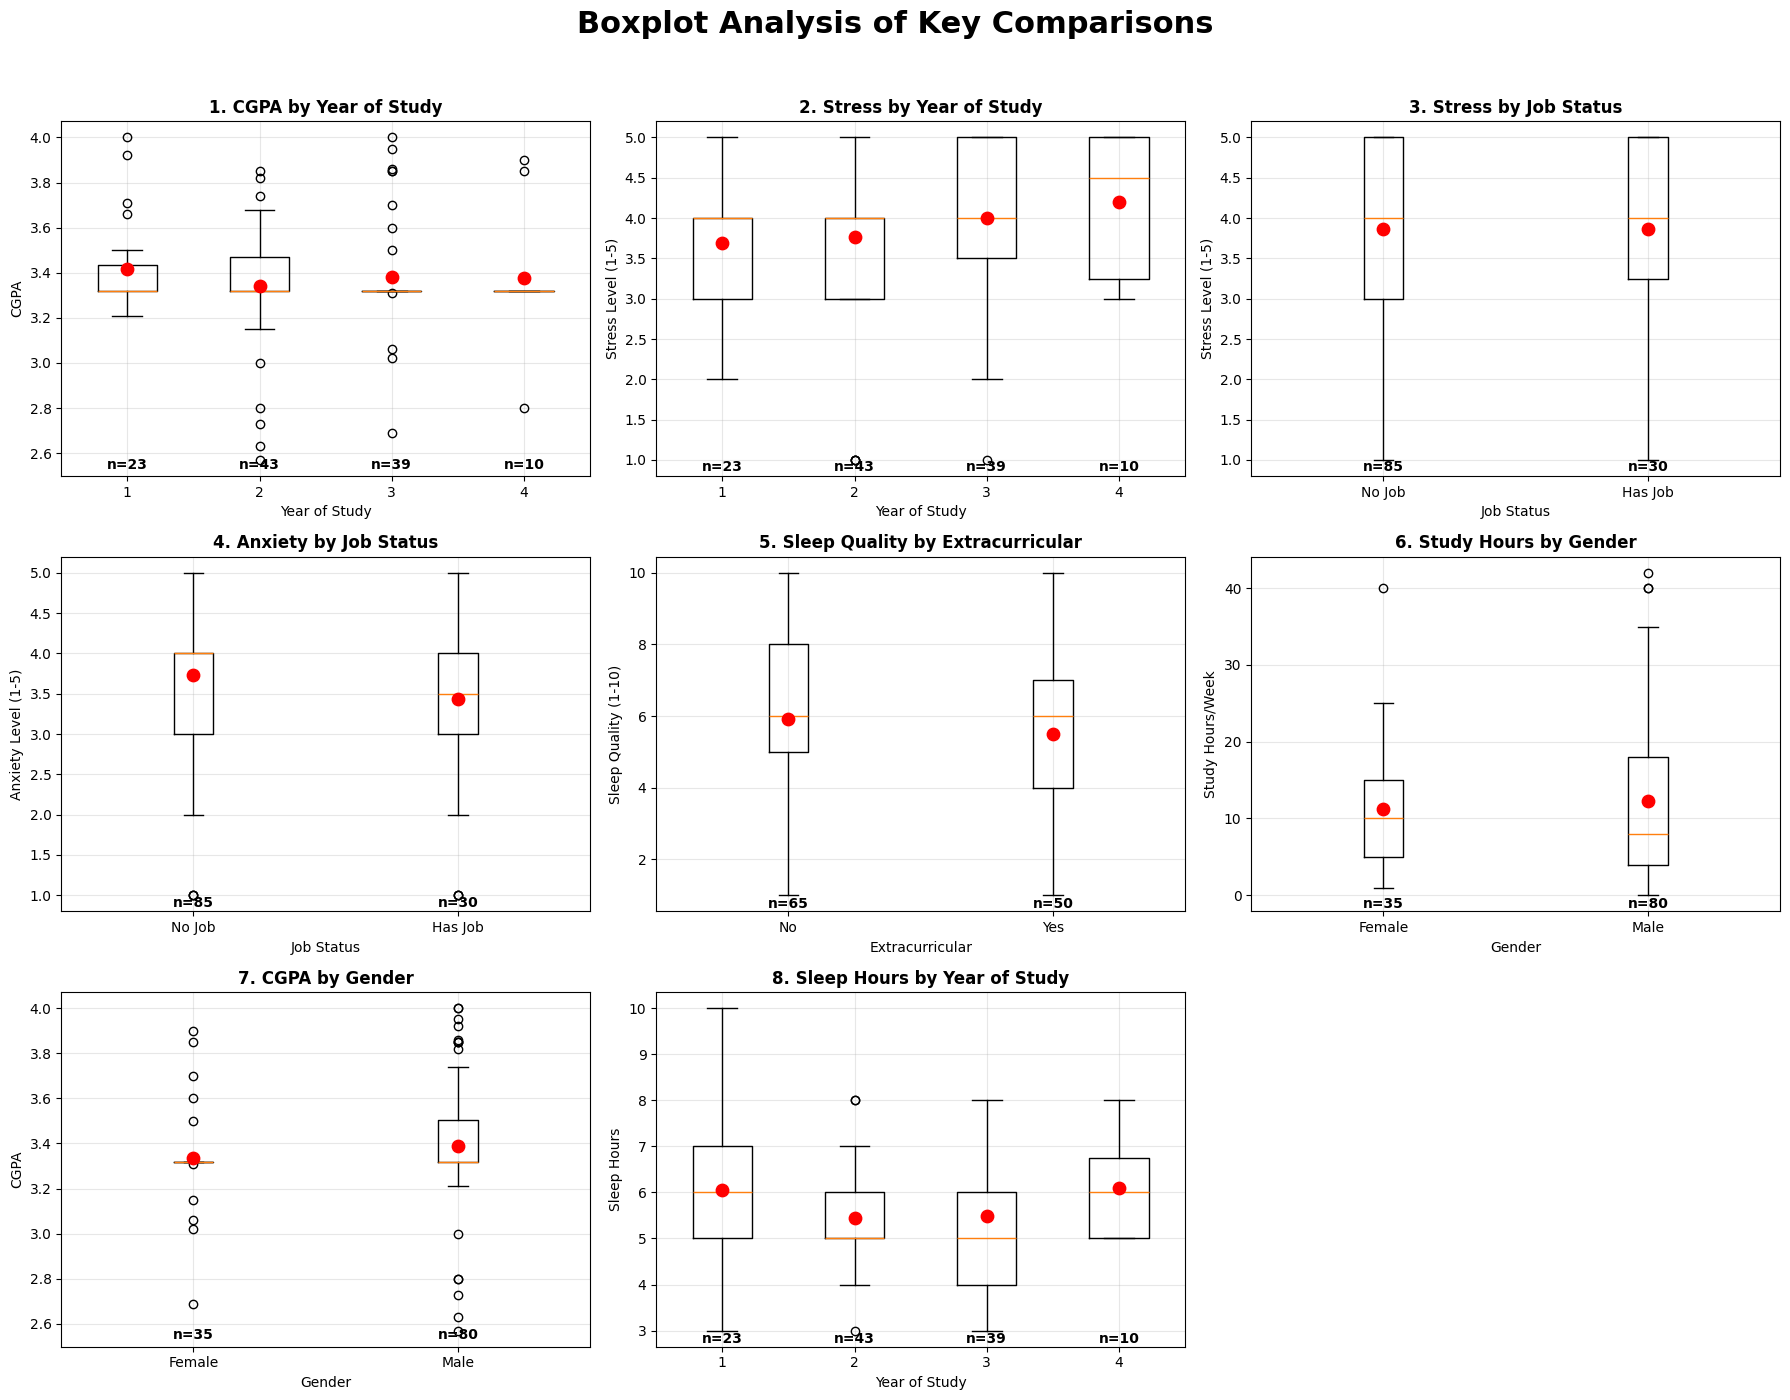


BASIC SUMMARY OF BOXPLOT ANALYSIS

GROUP COMPARISON SUMMARY:
----------------------------------------
Comparison               | Value Range        | p-value
--------------------------------------------------
CGPA by Year              | 3.34-3.42          | 0.7021
Stress by Year            | 3.7-4.2            | 0.4319
Stress by Job             | 3.9 vs 3.9         | 0.9857
Anxiety by Job            | 3.7 vs 3.4         | 0.1931
Sleep Quality by Extra    | 5.9 vs 5.5         | 0.2476
Study Hours by Gender     | 11.3 vs 12.3       | 0.6149
CGPA by Gender            | 3.33 vs 3.39       | 0.2861
Sleep Hours by Year       | 5.4-6.1            | 0.1831

Significant results: 0 out of 8 comparisons

QUICK INTERPRETATION:
--------------------
✗ CGPA by Year: No significant difference (p = 0.7021)
✗ Stress by Year: No significant difference (p = 0.4319)
✗ Stress by Job: No significant difference (p = 0.9857)
✗ Anxiety by Job: No significant difference (p = 0.1931)
✗ Sleep Quality by Extra: No

In [ ]:
# Boxplot Matrix
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
fig.suptitle('Boxplot Analysis of Key Comparisons', fontsize=22, fontweight='bold', y=0.98)

# 1. CGPA by Year of Study
categories = sorted(df['year_of_study'].unique())
data = [df[df['year_of_study'] == cat]['cgpa'] for cat in categories]
axes[0,0].boxplot(data, labels=categories)
axes[0,0].set_title('1. CGPA by Year of Study', fontweight='bold', fontsize=12)
axes[0,0].set_xlabel('Year of Study')
axes[0,0].set_ylabel('CGPA')
axes[0,0].grid(alpha=0.3)
# Add mean points
means = [np.mean(group) for group in data]
for i, mean_val in enumerate(means):
    axes[0,0].scatter(i + 1, mean_val, color='red', marker='o', s=80, zorder=3)
# Add sample sizes
for i, group in enumerate(data):
    axes[0,0].text(i + 1, axes[0,0].get_ylim()[0] + 0.02, f'n={len(group)}',
                  ha='center', va='bottom', fontweight='bold')

# 2. Stress by Year of Study
data = [df[df['year_of_study'] == cat]['stress_1to5'] for cat in categories]
axes[0,1].boxplot(data, labels=categories)
axes[0,1].set_title('2. Stress by Year of Study', fontweight='bold', fontsize=12)
axes[0,1].set_xlabel('Year of Study')
axes[0,1].set_ylabel('Stress Level (1-5)')
axes[0,1].grid(alpha=0.3)
means = [np.mean(group) for group in data]
for i, mean_val in enumerate(means):
    axes[0,1].scatter(i + 1, mean_val, color='red', marker='o', s=80, zorder=3)
for i, group in enumerate(data):
    axes[0,1].text(i + 1, axes[0,1].get_ylim()[0] + 0.02, f'n={len(group)}',
                  ha='center', va='bottom', fontweight='bold')

# 3. Stress by Job Status
categories = sorted(df['job'].unique())
data = [df[df['job'] == cat]['stress_1to5'] for cat in categories]
axes[0,2].boxplot(data, labels=['No Job', 'Has Job'])
axes[0,2].set_title('3. Stress by Job Status', fontweight='bold', fontsize=12)
axes[0,2].set_xlabel('Job Status')
axes[0,2].set_ylabel('Stress Level (1-5)')
axes[0,2].grid(alpha=0.3)
means = [np.mean(group) for group in data]
for i, mean_val in enumerate(means):
    axes[0,2].scatter(i + 1, mean_val, color='red', marker='o', s=80, zorder=3)
for i, group in enumerate(data):
    axes[0,2].text(i + 1, axes[0,2].get_ylim()[0] + 0.02, f'n={len(group)}',
                  ha='center', va='bottom', fontweight='bold')

# 4. Anxiety by Job Status
data = [df[df['job'] == cat]['anxiety_1to5'] for cat in categories]
axes[1,0].boxplot(data, labels=['No Job', 'Has Job'])
axes[1,0].set_title('4. Anxiety by Job Status', fontweight='bold', fontsize=12)
axes[1,0].set_xlabel('Job Status')
axes[1,0].set_ylabel('Anxiety Level (1-5)')
axes[1,0].grid(alpha=0.3)
means = [np.mean(group) for group in data]
for i, mean_val in enumerate(means):
    axes[1,0].scatter(i + 1, mean_val, color='red', marker='o', s=80, zorder=3)
for i, group in enumerate(data):
    axes[1,0].text(i + 1, axes[1,0].get_ylim()[0] + 0.02, f'n={len(group)}',
                  ha='center', va='bottom', fontweight='bold')

# 5. Sleep Quality by Extracurricular
categories = sorted(df['extracurricular'].unique())
data = [df[df['extracurricular'] == cat]['sleep_quality_1to10'] for cat in categories]
axes[1,1].boxplot(data, labels=['No', 'Yes'])
axes[1,1].set_title('5. Sleep Quality by Extracurricular', fontweight='bold', fontsize=12)
axes[1,1].set_xlabel('Extracurricular')
axes[1,1].set_ylabel('Sleep Quality (1-10)')
axes[1,1].grid(alpha=0.3)
means = [np.mean(group) for group in data]
for i, mean_val in enumerate(means):
    axes[1,1].scatter(i + 1, mean_val, color='red', marker='o', s=80, zorder=3)
for i, group in enumerate(data):
    axes[1,1].text(i + 1, axes[1,1].get_ylim()[0] + 0.02, f'n={len(group)}',
                  ha='center', va='bottom', fontweight='bold')

# 6. Study Hours by Gender
categories = sorted(df['gender'].unique())
data = [df[df['gender'] == cat]['study_hours_per_week'] for cat in categories]
axes[1,2].boxplot(data, labels=categories)
axes[1,2].set_title('6. Study Hours by Gender', fontweight='bold', fontsize=12)
axes[1,2].set_xlabel('Gender')
axes[1,2].set_ylabel('Study Hours/Week')
axes[1,2].grid(alpha=0.3)
means = [np.mean(group) for group in data]
for i, mean_val in enumerate(means):
    axes[1,2].scatter(i + 1, mean_val, color='red', marker='o', s=80, zorder=3)
for i, group in enumerate(data):
    axes[1,2].text(i + 1, axes[1,2].get_ylim()[0] + 0.02, f'n={len(group)}',
                  ha='center', va='bottom', fontweight='bold')

# 7. CGPA by Gender
data = [df[df['gender'] == cat]['cgpa'] for cat in categories]
axes[2,0].boxplot(data, labels=categories)
axes[2,0].set_title('7. CGPA by Gender', fontweight='bold', fontsize=12)
axes[2,0].set_xlabel('Gender')
axes[2,0].set_ylabel('CGPA')
axes[2,0].grid(alpha=0.3)
means = [np.mean(group) for group in data]
for i, mean_val in enumerate(means):
    axes[2,0].scatter(i + 1, mean_val, color='red', marker='o', s=80, zorder=3)
for i, group in enumerate(data):
    axes[2,0].text(i + 1, axes[2,0].get_ylim()[0] + 0.02, f'n={len(group)}',
                  ha='center', va='bottom', fontweight='bold')

# 8. Sleep Hours by Year of Study
categories = sorted(df['year_of_study'].unique())
data = [df[df['year_of_study'] == cat]['sleep_hours'] for cat in categories]
axes[2,1].boxplot(data, labels=categories)
axes[2,1].set_title('8. Sleep Hours by Year of Study', fontweight='bold', fontsize=12)
axes[2,1].set_xlabel('Year of Study')
axes[2,1].set_ylabel('Sleep Hours')
axes[2,1].grid(alpha=0.3)
means = [np.mean(group) for group in data]
for i, mean_val in enumerate(means):
    axes[2,1].scatter(i + 1, mean_val, color='red', marker='o', s=80, zorder=3)
for i, group in enumerate(data):
    axes[2,1].text(i + 1, axes[2,1].get_ylim()[0] + 0.02, f'n={len(group)}',
                  ha='center', va='bottom', fontweight='bold')

# Hide the empty subplot
axes[2,2].set_visible(False)

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()


# BASIC SUMMARY OF BOXPLOT ANALYSIS
print("\n" + "=" * 60)
print("BASIC SUMMARY OF BOXPLOT ANALYSIS")
print("=" * 60)

print("\nGROUP COMPARISON SUMMARY:")
print("-" * 40)

# Create summary data
summary_data = []

# 1. CGPA by Year of Study
years = sorted(df['year_of_study'].unique())
cgpa_means = [df[df['year_of_study'] == year]['cgpa'].mean() for year in years]
p_value = f_oneway(*[df[df['year_of_study'] == year]['cgpa'] for year in years])[1]
summary_data.append(["CGPA by Year", f"{min(cgpa_means):.2f}-{max(cgpa_means):.2f}", f"{p_value:.4f}"])

# 2. Stress by Year of Study
stress_means = [df[df['year_of_study'] == year]['stress_1to5'].mean() for year in years]
p_value = f_oneway(*[df[df['year_of_study'] == year]['stress_1to5'] for year in years])[1]
summary_data.append(["Stress by Year", f"{min(stress_means):.1f}-{max(stress_means):.1f}", f"{p_value:.4f}"])

# 3. Stress by Job Status
stress_no_job = df[df['job'] == 0]['stress_1to5'].mean()
stress_has_job = df[df['job'] == 1]['stress_1to5'].mean()
p_value = ttest_ind(df[df['job'] == 0]['stress_1to5'], df[df['job'] == 1]['stress_1to5'])[1]
summary_data.append(["Stress by Job", f"{stress_no_job:.1f} vs {stress_has_job:.1f}", f"{p_value:.4f}"])

# 4. Anxiety by Job Status
anxiety_no_job = df[df['job'] == 0]['anxiety_1to5'].mean()
anxiety_has_job = df[df['job'] == 1]['anxiety_1to5'].mean()
p_value = ttest_ind(df[df['job'] == 0]['anxiety_1to5'], df[df['job'] == 1]['anxiety_1to5'])[1]
summary_data.append(["Anxiety by Job", f"{anxiety_no_job:.1f} vs {anxiety_has_job:.1f}", f"{p_value:.4f}"])

# 5. Sleep Quality by Extracurricular
sleep_no_extra = df[df['extracurricular'] == 0]['sleep_quality_1to10'].mean()
sleep_has_extra = df[df['extracurricular'] == 1]['sleep_quality_1to10'].mean()
p_value = ttest_ind(df[df['extracurricular'] == 0]['sleep_quality_1to10'], df[df['extracurricular'] == 1]['sleep_quality_1to10'])[1]
summary_data.append(["Sleep Quality by Extra", f"{sleep_no_extra:.1f} vs {sleep_has_extra:.1f}", f"{p_value:.4f}"])

# 6. Study Hours by Gender
genders = sorted(df['gender'].unique())
if len(genders) == 2:
    study_g1 = df[df['gender'] == genders[0]]['study_hours_per_week'].mean()
    study_g2 = df[df['gender'] == genders[1]]['study_hours_per_week'].mean()
    p_value = ttest_ind(df[df['gender'] == genders[0]]['study_hours_per_week'], df[df['gender'] == genders[1]]['study_hours_per_week'])[1]
    summary_data.append(["Study Hours by Gender", f"{study_g1:.1f} vs {study_g2:.1f}", f"{p_value:.4f}"])

# 7. CGPA by Gender
if len(genders) == 2:
    cgpa_g1 = df[df['gender'] == genders[0]]['cgpa'].mean()
    cgpa_g2 = df[df['gender'] == genders[1]]['cgpa'].mean()
    p_value = ttest_ind(df[df['gender'] == genders[0]]['cgpa'], df[df['gender'] == genders[1]]['cgpa'])[1]
    summary_data.append(["CGPA by Gender", f"{cgpa_g1:.2f} vs {cgpa_g2:.2f}", f"{p_value:.4f}"])

# 8. Sleep Hours by Year of Study
sleep_means = [df[df['year_of_study'] == year]['sleep_hours'].mean() for year in years]
p_value = f_oneway(*[df[df['year_of_study'] == year]['sleep_hours'] for year in years])[1]
summary_data.append(["Sleep Hours by Year", f"{min(sleep_means):.1f}-{max(sleep_means):.1f}", f"{p_value:.4f}"])

# Print the summary table
print("Comparison               | Value Range        | p-value")
print("-" * 50)
for row in summary_data:
    print(f"{row[0]:25} | {row[1]:18} | {row[2]}")

# Count significant results
sig_count = sum(1 for row in summary_data if float(row[2]) < 0.05)
print(f"\nSignificant results: {sig_count} out of {len(summary_data)} comparisons")

# Quick interpretation
print("\nQUICK INTERPRETATION:")
print("-" * 20)
for row in summary_data:
    if float(row[2]) < 0.05:
        print(f"✓ {row[0]}: Significant difference (p = {row[2]})")
    else:
        print(f"✗ {row[0]}: No significant difference (p = {row[2]})")



# Hypothesis testing

In [ ]:
# Hypothesis Testing with Specified Statistical Methods
print("HYPOTHESIS TESTING RESULTS")
print("=" * 80)

# Set significance level
alpha = 0.05

# 1. Stress by extracurricular participation (Independent t-test)
print("\n1. STRESS BY EXTRACURRICULAR PARTICIPATION")
print("-" * 50)
print("H₀: μ₁ = μ₂ (No difference in mean stress between groups)")
print("H₁: μ₁ ≠ μ₂ (Difference in mean stress between groups)")
print(f"α = {alpha}")
print("Test: Independent t-test")

stress_extra_yes = df[df['extracurricular'] == 1]['stress_1to5']
stress_extra_no = df[df['extracurricular'] == 0]['stress_1to5']

print(f"\nGroup Statistics:")
print(f"Extracurricular (n={len(stress_extra_yes)}): M = {stress_extra_yes.mean():.2f}, SD = {stress_extra_yes.std():.2f}")
print(f"No extracurricular (n={len(stress_extra_no)}): M = {stress_extra_no.mean():.2f}, SD = {stress_extra_no.std():.2f}")

t_stat, p_value = ttest_ind(stress_extra_yes, stress_extra_no)
pooled_sd = np.sqrt(((len(stress_extra_yes)-1)*stress_extra_yes.var() +
                    (len(stress_extra_no)-1)*stress_extra_no.var()) /
                    (len(stress_extra_yes) + len(stress_extra_no) - 2))
cohens_d = (stress_extra_yes.mean() - stress_extra_no.mean()) / pooled_sd

print(f"\nResults: t({len(stress_extra_yes)+len(stress_extra_no)-2}) = {t_stat:.3f}, p = {p_value:.4f}")
print(f"Effect size (Cohen's d): {cohens_d:.3f}")

if p_value < alpha:
    print("CONCLUSION: Reject H₀ - Significant difference found")
    direction = "higher" if stress_extra_yes.mean() > stress_extra_no.mean() else "lower"
    print(f"Students with extracurricular activities have {direction} stress levels")
else:
    print("CONCLUSION: Fail to reject H₀ - No significant difference")

# 2. Anxiety across year of study (One-way ANOVA)
print("\n\n2. ANXIETY ACROSS YEAR OF STUDY")
print("-" * 50)
print("H₀: μ₁ = μ₂ = μ₃ = μ₄ (No difference in mean anxiety across years)")
print("H₁: At least one μ differs (Difference in mean anxiety across years)")
print(f"α = {alpha}")
print("Test: One-way ANOVA")

anxiety_by_year = [df[df['year_of_study'] == i]['anxiety_1to5'] for i in range(1, 5)]

print("\nGroup Statistics:")
for i in range(1, 5):
    group_data = df[df['year_of_study'] == i]['anxiety_1to5']
    print(f"Year {i} (n={len(group_data)}): M = {group_data.mean():.2f}, SD = {group_data.std():.2f}")

f_stat, p_value = f_oneway(*anxiety_by_year)
ss_between = sum(len(group) * (group.mean() - df['anxiety_1to5'].mean())**2 for group in anxiety_by_year)
ss_total = sum((x - df['anxiety_1to5'].mean())**2 for x in df['anxiety_1to5'])
eta_squared = ss_between / ss_total

print(f"\nResults: F({3}, {len(df)-4}) = {f_stat:.3f}, p = {p_value:.4f}")
print(f"Effect size (Eta squared): {eta_squared:.3f}")

if p_value < alpha:
    print("CONCLUSION: Reject H₀ - Significant differences across years")
else:
    print("CONCLUSION: Fail to reject H₀ - No significant differences")

# 3. Study hours vs. stress (Correlation test)
print("\n\n3. STUDY HOURS VS. STRESS")
print("-" * 50)
print("H₀: ρ = 0 (No correlation between study hours and stress)")
print("H₁: ρ ≠ 0 (Correlation exists between study hours and stress)")
print(f"α = {alpha}")
print("Test: Pearson correlation")

corr, p_value = pearsonr(df['study_hours_per_week'], df['stress_1to5'])

print(f"\nDescriptive Statistics:")
print(f"Study hours: M = {df['study_hours_per_week'].mean():.2f}, SD = {df['study_hours_per_week'].std():.2f}")
print(f"Stress: M = {df['stress_1to5'].mean():.2f}, SD = {df['stress_1to5'].std():.2f}")

print(f"\nResults: r({len(df)-2}) = {corr:.3f}, p = {p_value:.4f}")
print(f"Effect size (r): {corr:.3f}")

if p_value < alpha:
    print("CONCLUSION: Reject H₀ - Significant correlation found")
    direction = "positive" if corr > 0 else "negative"
    print(f"{direction.capitalize()} relationship: More study hours associated with {direction} stress")
else:
    print("CONCLUSION: Fail to reject H₀ - No significant correlation")

# 4. Sleep hours vs. anxiety (Correlation test)
print("\n\n4. SLEEP HOURS VS. ANXIETY")
print("-" * 50)
print("H₀: ρ = 0 (No correlation between sleep hours and anxiety)")
print("H₁: ρ ≠ 0 (Correlation exists between sleep hours and anxiety)")
print(f"α = {alpha}")
print("Test: Pearson correlation")

corr, p_value = pearsonr(df['sleep_hours'], df['anxiety_1to5'])

print(f"\nDescriptive Statistics:")
print(f"Sleep hours: M = {df['sleep_hours'].mean():.2f}, SD = {df['sleep_hours'].std():.2f}")
print(f"Anxiety: M = {df['anxiety_1to5'].mean():.2f}, SD = {df['anxiety_1to5'].std():.2f}")

print(f"\nResults: r({len(df)-2}) = {corr:.3f}, p = {p_value:.4f}")
print(f"Effect size (r): {corr:.3f}")

if p_value < alpha:
    print("CONCLUSION: Reject H₀ - Significant correlation found")
    direction = "positive" if corr > 0 else "negative"
    print(f"{direction.capitalize()} relationship: More sleep hours associated with {direction} anxiety")
else:
    print("CONCLUSION: Fail to reject H₀ - No significant correlation")

# 5. High stress proportions by job status (Proportion test using chi-square)
print("\n\n5. HIGH STRESS PROPORTIONS BY JOB STATUS")
print("-" * 50)
print("H₀: p₁ = p₂ (No difference in high stress proportion between job groups)")
print("H₁: p₁ ≠ p₂ (Difference in high stress proportion between job groups)")
print(f"α = {alpha}")
print("Test: Chi-square test of independence")

df['high_stress'] = (df['stress_1to5'] >= 4).astype(int)
contingency_table = pd.crosstab(df['job'], df['high_stress'])

print("\nContingency Table:")
print(contingency_table)

prop_no_job = contingency_table.loc[0, 1] / contingency_table.loc[0].sum()
prop_has_job = contingency_table.loc[1, 1] / contingency_table.loc[1].sum()

print(f"\nProportions:")
print(f"No job: {contingency_table.loc[0, 1]}/{contingency_table.loc[0].sum()} = {prop_no_job:.3f}")
print(f"Has job: {contingency_table.loc[1, 1]}/{contingency_table.loc[1].sum()} = {prop_has_job:.3f}")

chi2, p_value, dof, expected = chi2_contingency(contingency_table)
n = len(df)
cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

print(f"\nResults: χ²({dof}, N={n}) = {chi2:.3f}, p = {p_value:.4f}")
print(f"Effect size (Cramer's V): {cramers_v:.3f}")

if p_value < alpha:
    print("CONCLUSION: Reject H₀ - Significant difference in proportions")
    higher_group = "no job" if prop_no_job > prop_has_job else "has job"
    print(f"Students with {higher_group} have higher proportion of high stress")
else:
    print("CONCLUSION: Fail to reject H₀ - No significant difference")

# 6. Multiple regression predicting stress
print("\n\n6. MULTIPLE REGRESSION PREDICTING STRESS")
print("-" * 50)
print("H₀: β = 0 (Predictor has no effect on stress controlling for other variables)")
print("H₁: β ≠ 0 (Predictor has effect on stress controlling for other variables)")
print(f"α = {alpha}")
print("Test: Multiple regression with t-tests for coefficients")

# Prepare regression data
X_vars = ['study_hours_per_week', 'sleep_hours', 'sleep_quality_1to10',
          'extracurricular', 'job', 'year_of_study']
X = df[X_vars]
y = df['stress_1to5']

if HAS_SM:
    # Use statsmodels for detailed output
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()

    print("\nRegression Results (statsmodels):")
    print(model.summary())

    print(f"\nOverall model: R² = {model.rsquared:.3f}, F = {model.fvalue:.3f}, p = {model.f_pvalue:.4f}")
    print("Significant predictors (α = 0.05):")

    significant_predictors = []
    for i, var in enumerate(X_vars):
        p_val = model.pvalues[i+1]  # +1 for constant
        if p_val < alpha:
            coef = model.params[i+1]
            significant_predictors.append((var, coef, p_val))
            print(f"- {var}: β = {coef:.3f}, p = {p_val:.4f}")

    if not significant_predictors:
        print("No significant predictors found")

else:
    # Fallback to scikit-learn
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score

    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)

    print(f"\nRegression Results (scikit-learn):")
    print(f"R² = {r2:.3f}")
    print("Coefficients:")
    for var, coef in zip(X_vars, model.coef_):
        print(f"- {var}: β = {coef:.3f}")

    print("\nNote: p-values not available with scikit-learn. Use statsmodels for significance testing.")

# Print comprehensive summary
print("\n" + "=" * 80)
print("HYPOTHESIS TESTING SUMMARY")
print("=" * 80)

summary_data = []
tests = [
    ("Stress by extracurricular", ttest_ind(stress_extra_yes, stress_extra_no)[1]),
    ("Anxiety across years", f_oneway(*anxiety_by_year)[1]),
    ("Study hours vs stress", pearsonr(df['study_hours_per_week'], df['stress_1to5'])[1]),
    ("Sleep hours vs anxiety", pearsonr(df['sleep_hours'], df['anxiety_1to5'])[1]),
    ("High stress by job", chi2_contingency(contingency_table)[1])
]

for test_name, p_val in tests:
    significance = "Significant" if p_val < alpha else "Not significant"
    conclusion = "Reject H₀" if p_val < alpha else "Fail to reject H₀"
    summary_data.append([test_name, f"{p_val:.4f}", significance, conclusion])

summary_df = pd.DataFrame(summary_data, columns=['Test', 'p-value', 'Significance', 'Conclusion'])
print(summary_df.to_string(index=False))

print(f"\nOverall interpretation:")
sig_count = sum(1 for _, p_val in tests if p_val < alpha)
print(f"{sig_count} out of {len(tests)} tests showed significant results at α = {alpha}")

HYPOTHESIS TESTING RESULTS

1. STRESS BY EXTRACURRICULAR PARTICIPATION
--------------------------------------------------
H₀: μ₁ = μ₂ (No difference in mean stress between groups)
H₁: μ₁ ≠ μ₂ (Difference in mean stress between groups)
α = 0.05
Test: Independent t-test

Group Statistics:
Extracurricular (n=50): M = 3.88, SD = 0.87
No extracurricular (n=65): M = 3.86, SD = 1.13

Results: t(113) = 0.096, p = 0.9240
Effect size (Cohen's d): 0.018
CONCLUSION: Fail to reject H₀ - No significant difference


2. ANXIETY ACROSS YEAR OF STUDY
--------------------------------------------------
H₀: μ₁ = μ₂ = μ₃ = μ₄ (No difference in mean anxiety across years)
H₁: At least one μ differs (Difference in mean anxiety across years)
α = 0.05
Test: One-way ANOVA

Group Statistics:
Year 1 (n=23): M = 3.48, SD = 0.99
Year 2 (n=43): M = 3.44, SD = 1.12
Year 3 (n=39): M = 4.00, SD = 1.03
Year 4 (n=10): M = 3.60, SD = 0.97

Results: F(3, 111) = 2.214, p = 0.0905
Effect size (Eta squared): 0.056
CONCLUSION: F

/tmp/ipython-input-3292839137.py:177: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_val = model.pvalues[i+1]  # +1 for constant
/tmp/ipython-input-3292839137.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  coef = model.params[i+1]


#Regression Modeling


1. SIMPLE REGRESSION: Stress ~ Study Hours
                            OLS Regression Results                            
Dep. Variable:            stress_1to5   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     3.603
Date:                Sat, 13 Sep 2025   Prob (F-statistic):             0.0602
Time:                        23:43:26   Log-Likelihood:                -163.36
No. Observations:                 115   AIC:                             330.7
Df Residuals:                     113   BIC:                             336.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

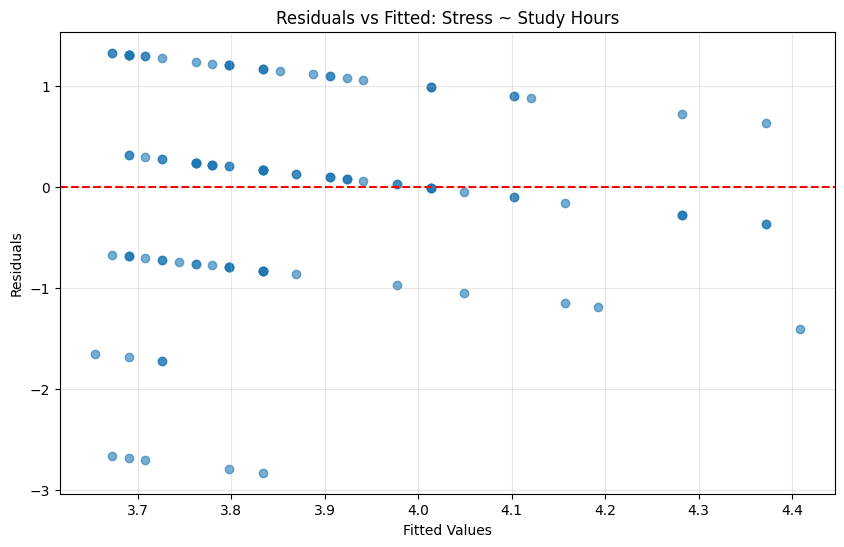

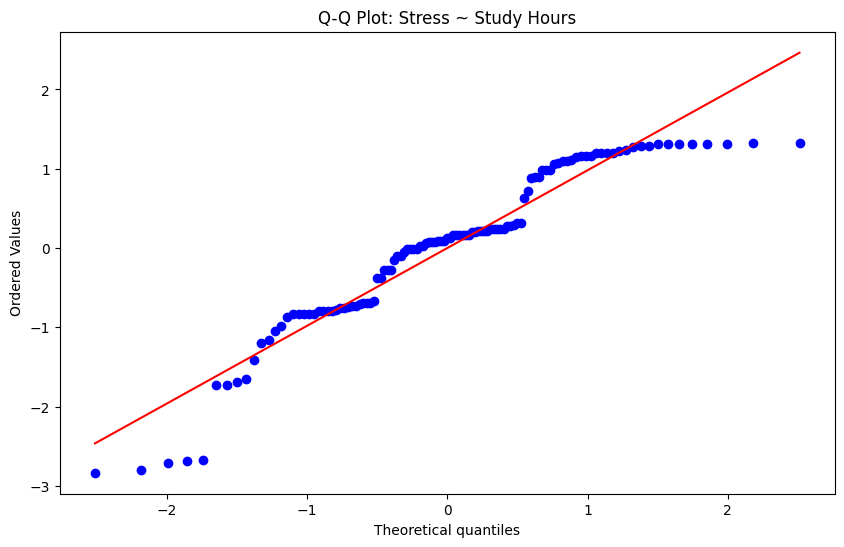

Shapiro-Wilk normality test: p = 0.0000


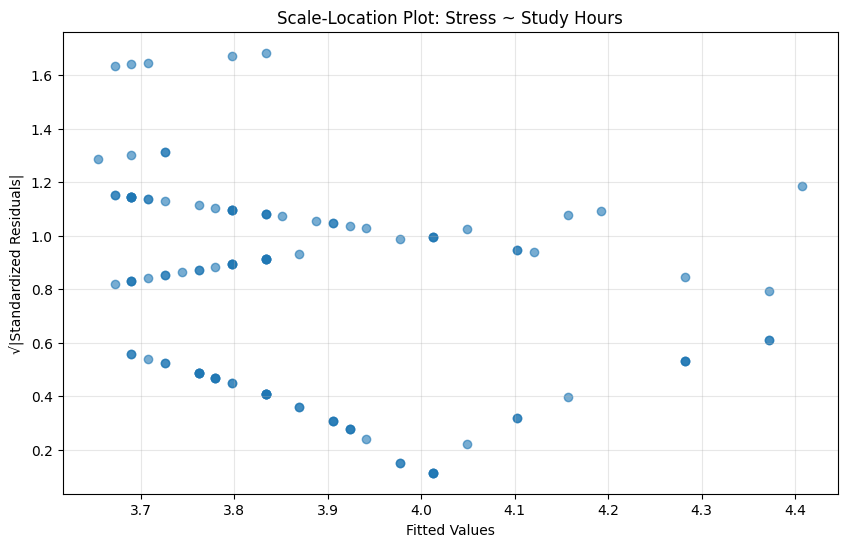

Durbin-Watson: 1.770
Breusch-Pagan: p = 0.0074


In [ ]:
# 1. Stress ~ Study Hours (Simple Regression)
print("1. SIMPLE REGRESSION: Stress ~ Study Hours")
print("=" * 50)

# Prepare data
X = df[['study_hours_per_week']]
y = df['stress_1to5']

# Fit model
if HAS_SM:
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    print(model.summary())
else:
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    print(f"R² = {r2:.3f}")
    print(f"Coefficient = {model.coef_[0]:.3f}")
    print(f"Intercept = {model.intercept_:.3f}")

# Assumption checking
print("\nASSUMPTION CHECKING:")
print("-" * 30)

if HAS_SM:
    residuals = model.resid
    fitted = model.fittedvalues
else:
    residuals = y - model.predict(X)
    fitted = model.predict(X)

# Linearity
plt.figure(figsize=(10, 6))
plt.scatter(fitted, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted: Stress ~ Study Hours')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(alpha=0.3)
plt.show()

# Normality
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot: Stress ~ Study Hours')
plt.show()

shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"Shapiro-Wilk normality test: p = {shapiro_p:.4f}")

# Homoscedasticity
plt.figure(figsize=(10, 6))
residuals_std = np.sqrt(np.abs(residuals))
plt.scatter(fitted, residuals_std, alpha=0.6)
plt.title('Scale-Location Plot: Stress ~ Study Hours')
plt.xlabel('Fitted Values')
plt.ylabel('√|Standardized Residuals|')
plt.grid(alpha=0.3)
plt.show()

if HAS_SM:
    # Independence
    dw = sm.stats.stattools.durbin_watson(residuals)
    print(f"Durbin-Watson: {dw:.3f}")

    # Breusch-Pagan
    try:
        bp_test = het_breuschpagan(residuals, model.model.exog)
        print(f"Breusch-Pagan: p = {bp_test[1]:.4f}")
    except:
        pass

2. SIMPLE REGRESSION: Stress ~ Year of Study
                            OLS Regression Results                            
Dep. Variable:            stress_1to5   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     2.638
Date:                Sat, 13 Sep 2025   Prob (F-statistic):              0.107
Time:                        23:43:27   Log-Likelihood:                -163.84
No. Observations:                 115   AIC:                             331.7
Df Residuals:                     113   BIC:                             337.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
c

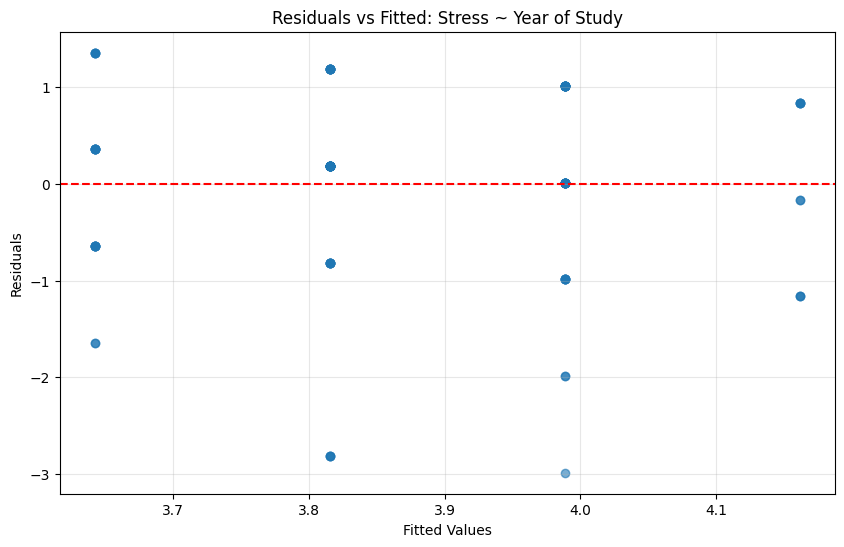

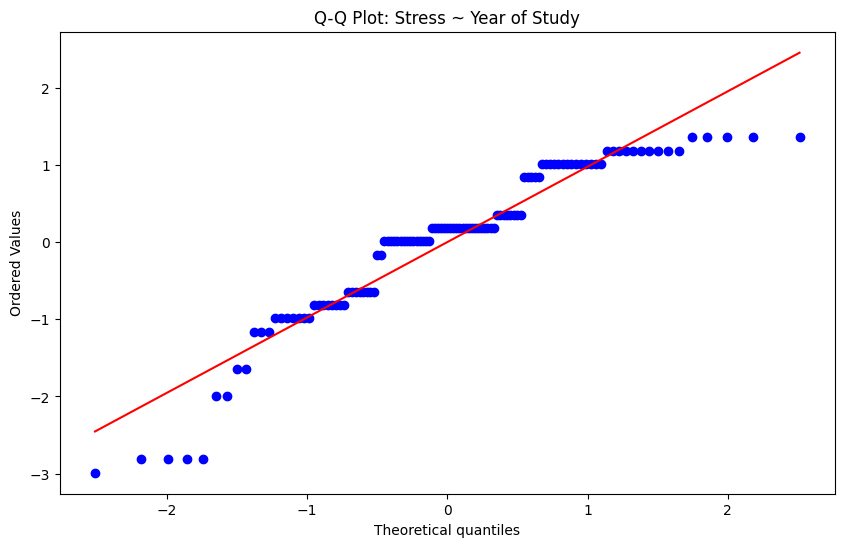

Shapiro-Wilk normality test: p = 0.0000


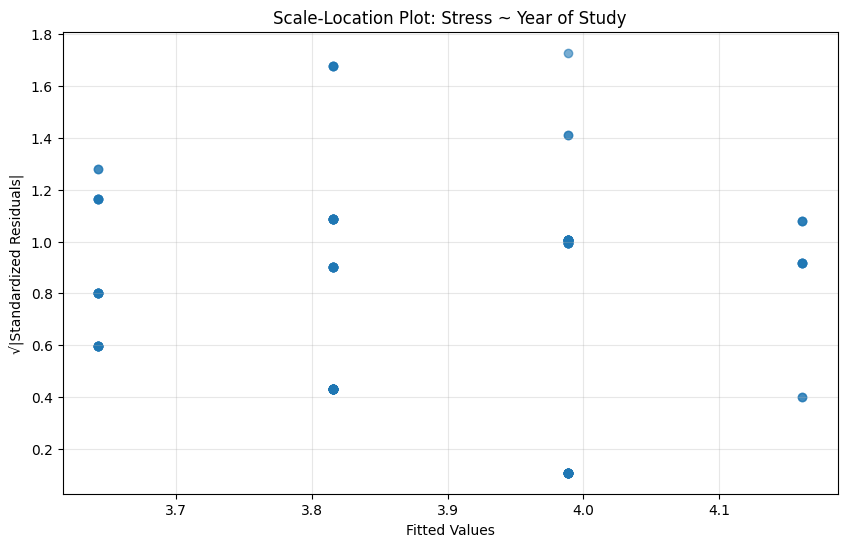

Durbin-Watson: 1.783


In [ ]:
# 2. Stress ~ Year of Study (Simple Regression)
print("2. SIMPLE REGRESSION: Stress ~ Year of Study")
print("=" * 50)

# Prepare data
X = df[['year_of_study']]
y = df['stress_1to5']

# Fit model
if HAS_SM:
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    print(model.summary())
else:
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    print(f"R² = {r2:.3f}")
    print(f"Coefficient = {model.coef_[0]:.3f}")
    print(f"Intercept = {model.intercept_:.3f}")

# Assumption checking
print("\nASSUMPTION CHECKING:")
print("-" * 30)

if HAS_SM:
    residuals = model.resid
    fitted = model.fittedvalues
else:
    residuals = y - model.predict(X)
    fitted = model.predict(X)

# Linearity
plt.figure(figsize=(10, 6))
plt.scatter(fitted, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted: Stress ~ Year of Study')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(alpha=0.3)
plt.show()

# Normality
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot: Stress ~ Year of Study')
plt.show()

shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"Shapiro-Wilk normality test: p = {shapiro_p:.4f}")

# Homoscedasticity
plt.figure(figsize=(10, 6))
residuals_std = np.sqrt(np.abs(residuals))
plt.scatter(fitted, residuals_std, alpha=0.6)
plt.title('Scale-Location Plot: Stress ~ Year of Study')
plt.xlabel('Fitted Values')
plt.ylabel('√|Standardized Residuals|')
plt.grid(alpha=0.3)
plt.show()

if HAS_SM:
    dw = sm.stats.stattools.durbin_watson(residuals)
    print(f"Durbin-Watson: {dw:.3f}")

3. SIMPLE REGRESSION: Anxiety ~ Sleep Quality
                            OLS Regression Results                            
Dep. Variable:           anxiety_1to5   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.055
Method:                 Least Squares   F-statistic:                     7.652
Date:                Sat, 13 Sep 2025   Prob (F-statistic):            0.00663
Time:                        23:43:28   Log-Likelihood:                -166.50
No. Observations:                 115   AIC:                             337.0
Df Residuals:                     113   BIC:                             342.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

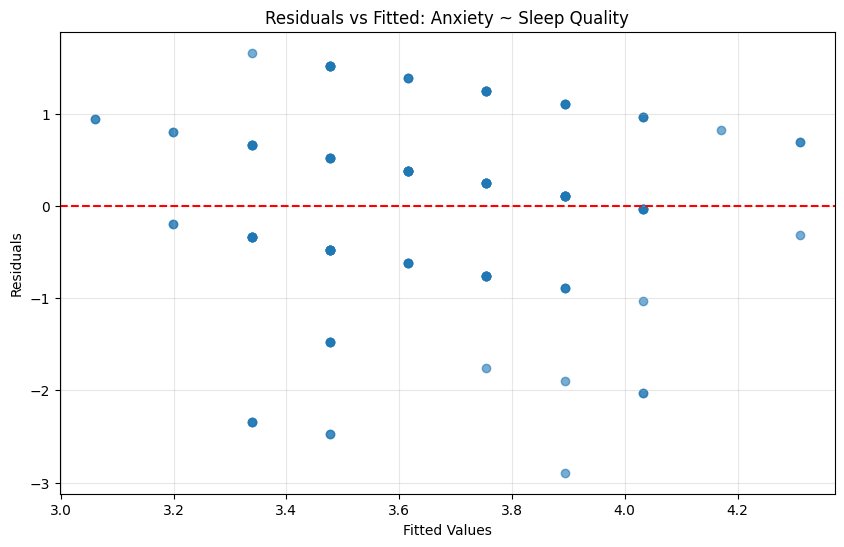

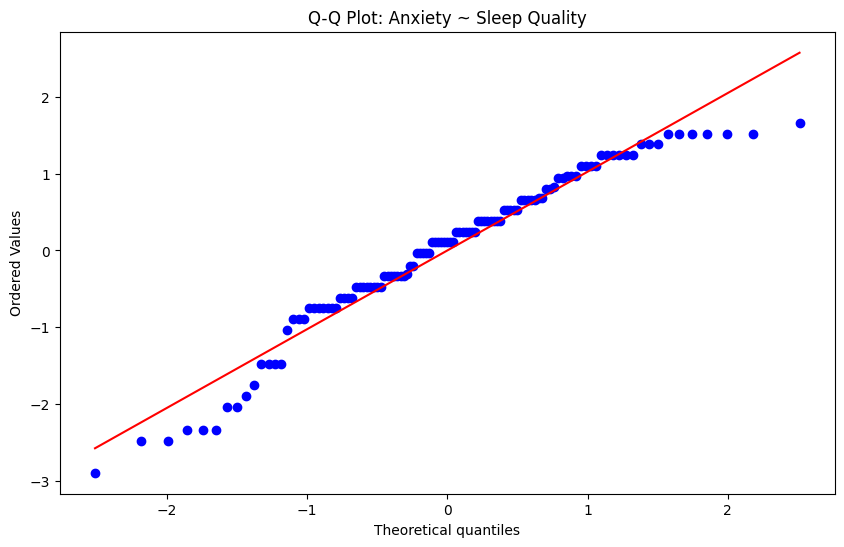

Shapiro-Wilk normality test: p = 0.0005


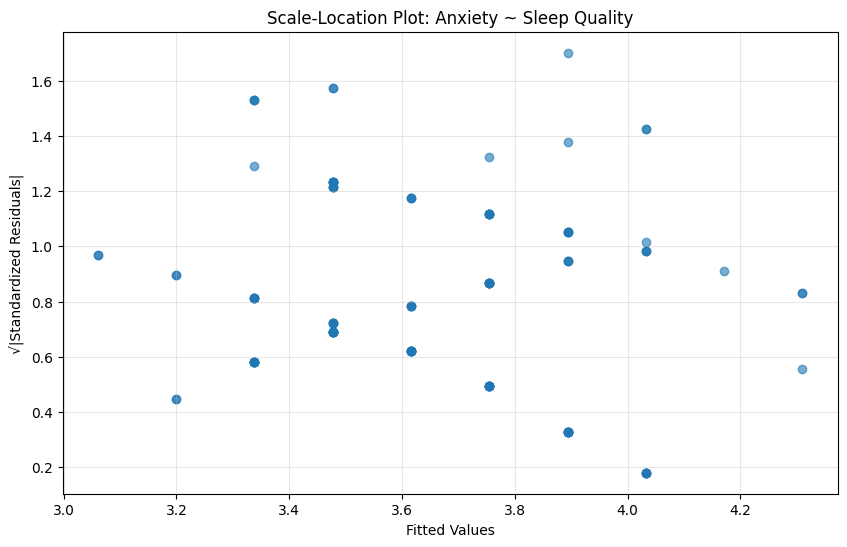

Durbin-Watson: 2.102


In [ ]:
# 3. Anxiety ~ Sleep Quality (Simple Regression)
print("3. SIMPLE REGRESSION: Anxiety ~ Sleep Quality")
print("=" * 50)

# Prepare data
X = df[['sleep_quality_1to10']]
y = df['anxiety_1to5']

# Fit model
if HAS_SM:
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    print(model.summary())
else:
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    print(f"R² = {r2:.3f}")
    print(f"Coefficient = {model.coef_[0]:.3f}")
    print(f"Intercept = {model.intercept_:.3f}")

# Assumption checking
print("\nASSUMPTION CHECKING:")
print("-" * 30)

if HAS_SM:
    residuals = model.resid
    fitted = model.fittedvalues
else:
    residuals = y - model.predict(X)
    fitted = model.predict(X)

# Linearity
plt.figure(figsize=(10, 6))
plt.scatter(fitted, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted: Anxiety ~ Sleep Quality')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(alpha=0.3)
plt.show()

# Normality
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot: Anxiety ~ Sleep Quality')
plt.show()

shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"Shapiro-Wilk normality test: p = {shapiro_p:.4f}")

# Homoscedasticity
plt.figure(figsize=(10, 6))
residuals_std = np.sqrt(np.abs(residuals))
plt.scatter(fitted, residuals_std, alpha=0.6)
plt.title('Scale-Location Plot: Anxiety ~ Sleep Quality')
plt.xlabel('Fitted Values')
plt.ylabel('√|Standardized Residuals|')
plt.grid(alpha=0.3)
plt.show()

if HAS_SM:
    dw = sm.stats.stattools.durbin_watson(residuals)
    print(f"Durbin-Watson: {dw:.3f}")

4. MULTIPLE REGRESSION: Stress ~ Multiple Predictors
                            OLS Regression Results                            
Dep. Variable:            stress_1to5   R-squared:                       0.069
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     1.615
Date:                Sat, 13 Sep 2025   Prob (F-statistic):              0.162
Time:                        23:43:28   Log-Likelihood:                -161.06
No. Observations:                 115   AIC:                             334.1
Df Residuals:                     109   BIC:                             350.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

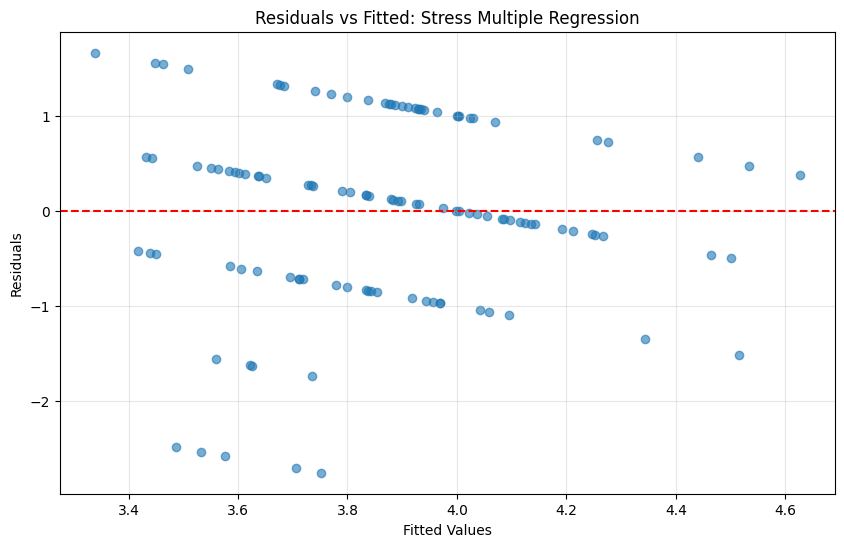

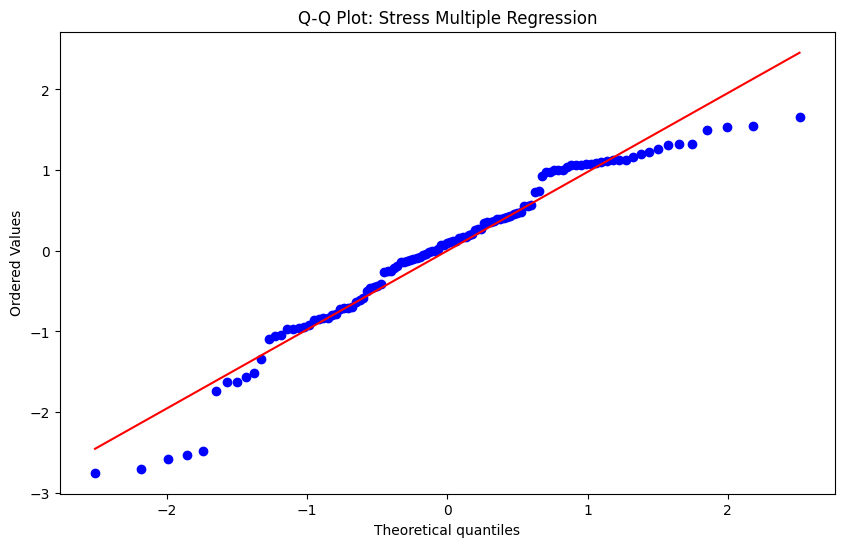

Shapiro-Wilk normality test: p = 0.0006


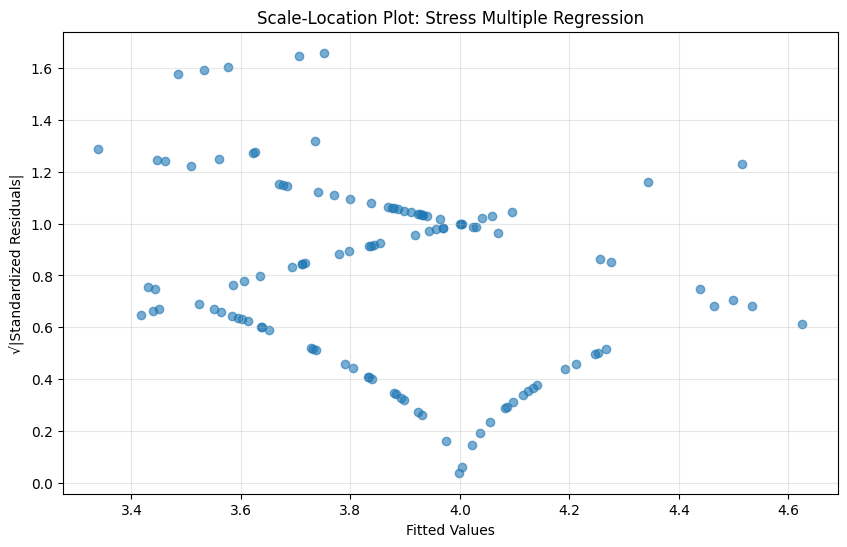

Durbin-Watson: 1.783
Breusch-Pagan: p = 0.0297
Rainbow test for linearity: p = 0.7983


In [ ]:
# 4. Stress ~ Study Hours + Courses + Extracurricular Hours + Job Hours + Sleep Quality
print("4. MULTIPLE REGRESSION: Stress ~ Multiple Predictors")
print("=" * 60)

# Prepare data
X = df[['study_hours_per_week', 'courses_enrolled',
        'extracurricular_hours', 'job_hours_per_week', 'sleep_quality_1to10']]
y = df['stress_1to5']

# Fit model
if HAS_SM:
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    print(model.summary())

    # Check multicollinearity
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\nVariance Inflation Factors (VIF):")
    print(vif_data)

else:
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    print(f"R² = {r2:.3f}")
    print("Coefficients:")
    for i, col in enumerate(X.columns):
        print(f"{col:20}: {model.coef_[i]:.3f}")

# Assumption checking
print("\nASSUMPTION CHECKING:")
print("-" * 30)

if HAS_SM:
    residuals = model.resid
    fitted = model.fittedvalues
else:
    residuals = y - model.predict(X)
    fitted = model.predict(X)

# Linearity
plt.figure(figsize=(10, 6))
plt.scatter(fitted, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted: Stress Multiple Regression')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(alpha=0.3)
plt.show()

# Normality
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot: Stress Multiple Regression')
plt.show()

shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"Shapiro-Wilk normality test: p = {shapiro_p:.4f}")

# Homoscedasticity
plt.figure(figsize=(10, 6))
residuals_std = np.sqrt(np.abs(residuals))
plt.scatter(fitted, residuals_std, alpha=0.6)
plt.title('Scale-Location Plot: Stress Multiple Regression')
plt.xlabel('Fitted Values')
plt.ylabel('√|Standardized Residuals|')
plt.grid(alpha=0.3)
plt.show()

if HAS_SM:
    # Independence
    dw = sm.stats.stattools.durbin_watson(residuals)
    print(f"Durbin-Watson: {dw:.3f}")

    # Breusch-Pagan
    try:
        bp_test = het_breuschpagan(residuals, model.model.exog)
        print(f"Breusch-Pagan: p = {bp_test[1]:.4f}")
    except:
        pass

    # Rainbow test for linearity
    try:
        from statsmodels.stats.diagnostic import linear_rainbow
        rainbow_stat, rainbow_p = linear_rainbow(model)
        print(f"Rainbow test for linearity: p = {rainbow_p:.4f}")
    except:
        pass

5. MULTIPLE REGRESSION: Sleep Quality ~ Multiple Predictors
                             OLS Regression Results                            
Dep. Variable:     sleep_quality_1to10   R-squared:                       0.216
Model:                             OLS   Adj. R-squared:                  0.195
Method:                  Least Squares   F-statistic:                     10.20
Date:                 Sat, 13 Sep 2025   Prob (F-statistic):           5.50e-06
Time:                         23:43:29   Log-Likelihood:                -224.77
No. Observations:                  115   AIC:                             457.5
Df Residuals:                      111   BIC:                             468.5
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

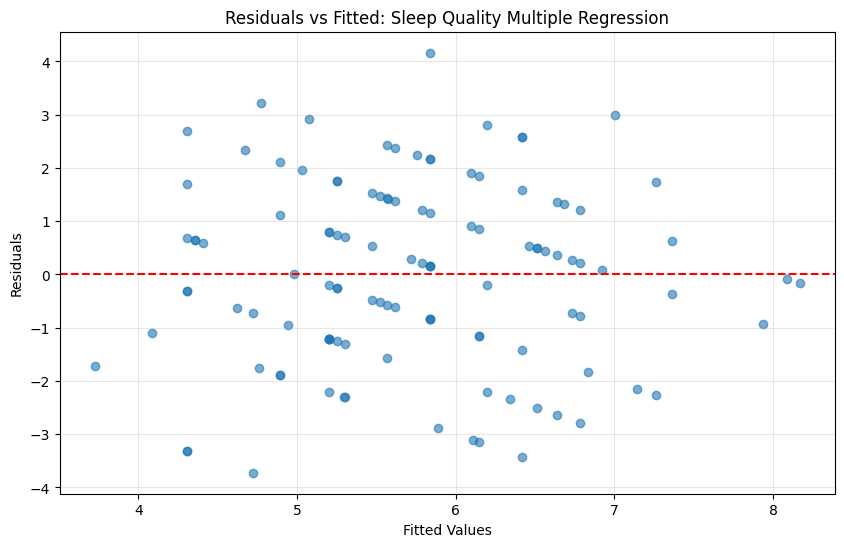

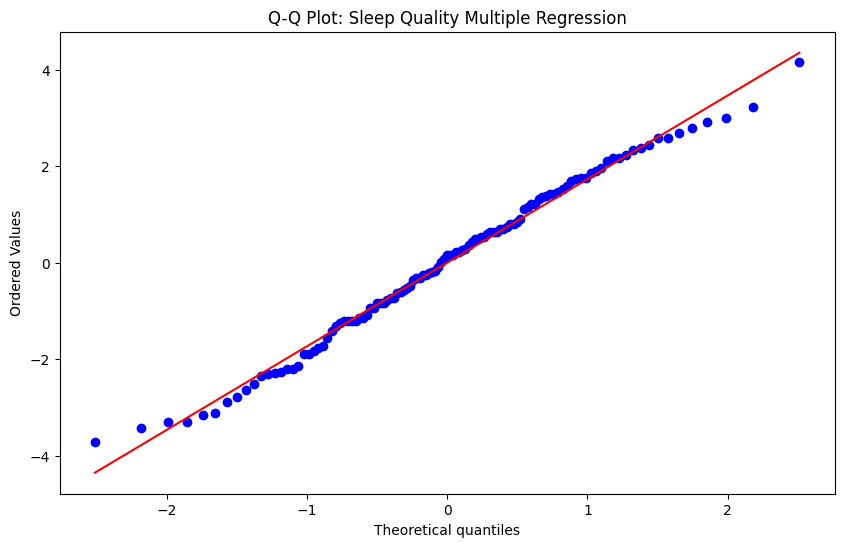

Shapiro-Wilk normality test: p = 0.4659


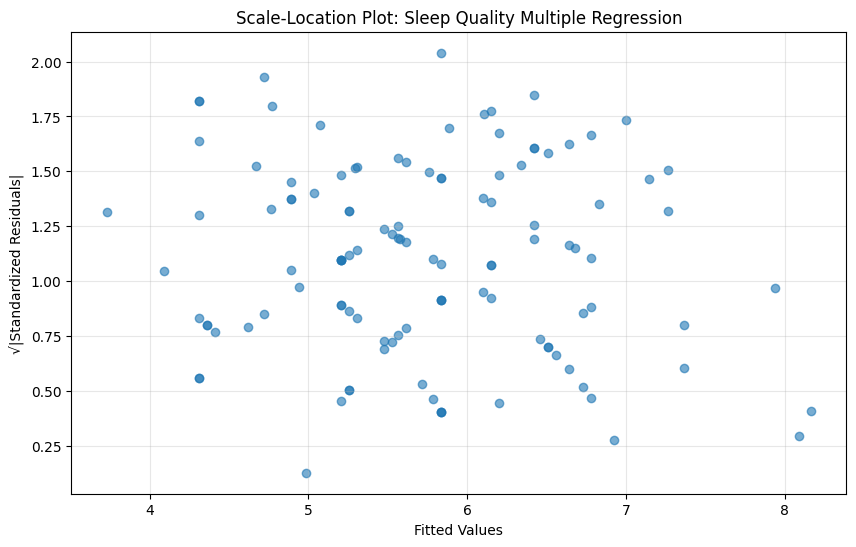

Durbin-Watson: 2.009
Breusch-Pagan: p = 0.6772
Rainbow test for linearity: p = 0.1600


In [ ]:
# 5. Sleep Quality ~ Sleep Hours + Stress + Anxiety
print("5. MULTIPLE REGRESSION: Sleep Quality ~ Multiple Predictors")
print("=" * 60)

# Prepare data
X = df[['sleep_hours', 'stress_1to5', 'anxiety_1to5']]
y = df['sleep_quality_1to10']

# Fit model
if HAS_SM:
    X_const = sm.add_constant(X)
    model = sm.OLS(y, X_const).fit()
    print(model.summary())

    # Check multicollinearity
    from statsmodels.stats.outliers_influence import variance_inflation_factor
    vif_data = pd.DataFrame()
    vif_data["Variable"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\nVariance Inflation Factors (VIF):")
    print(vif_data)

else:
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import r2_score
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    print(f"R² = {r2:.3f}")
    print("Coefficients:")
    for i, col in enumerate(X.columns):
        print(f"{col:20}: {model.coef_[i]:.3f}")

# Assumption checking
print("\nASSUMPTION CHECKING:")
print("-" * 30)

if HAS_SM:
    residuals = model.resid
    fitted = model.fittedvalues
else:
    residuals = y - model.predict(X)
    fitted = model.predict(X)

# Linearity
plt.figure(figsize=(10, 6))
plt.scatter(fitted, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals vs Fitted: Sleep Quality Multiple Regression')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(alpha=0.3)
plt.show()

# Normality
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot: Sleep Quality Multiple Regression')
plt.show()

shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"Shapiro-Wilk normality test: p = {shapiro_p:.4f}")

# Homoscedasticity
plt.figure(figsize=(10, 6))
residuals_std = np.sqrt(np.abs(residuals))
plt.scatter(fitted, residuals_std, alpha=0.6)
plt.title('Scale-Location Plot: Sleep Quality Multiple Regression')
plt.xlabel('Fitted Values')
plt.ylabel('√|Standardized Residuals|')
plt.grid(alpha=0.3)
plt.show()

if HAS_SM:
    # Independence
    dw = sm.stats.stattools.durbin_watson(residuals)
    print(f"Durbin-Watson: {dw:.3f}")

    # Breusch-Pagan
    try:
        bp_test = het_breuschpagan(residuals, model.model.exog)
        print(f"Breusch-Pagan: p = {bp_test[1]:.4f}")
    except:
        pass

    # Rainbow test for linearity
    try:
        from statsmodels.stats.diagnostic import linear_rainbow
        rainbow_stat, rainbow_p = linear_rainbow(model)
        print(f"Rainbow test for linearity: p = {rainbow_p:.4f}")
    except:
        pass

# Dashboard
https://xhafan-dashboard1.streamlit.app/